## Introduction

In this workshop, you will practice the following skills:

1. Using various clustering methods (e.g. kmeans, DBSCAN, hierarchical, max-p) to analyse the housing price and population data in London; 
2. Describing and analysing the clustering results;
3. Selecting the key parameters for kmeans clustering and hierarchical clustering.

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2025-03-06 19:10:30


In [126]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from esda.getisord import G_Local
from libpysal.weights import KNN

from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from spopt.region import MaxPHeuristic as MaxP

from scipy.cluster.hierarchy import dendrogram

import libpysal
import warnings


### Spatial data

In [96]:
#load in the LSOA map 
UK_LSOA = gpd.read_file("./data/LSOA.gpkg")

## 23_25 data

In [4]:
crime23_25 = pd.read_csv('./data/MPS LSOA Level Crime (most recent 24 months).csv')
crime23_25.head()

LSOA Code                  LSOA Name    Borough             Major Category  \
0  E01000006  Barking and Dagenham 016A  E09000002  ARSON AND CRIMINAL DAMAGE   
1  E01000006  Barking and Dagenham 016A  E09000002                   BURGLARY   
2  E01000006  Barking and Dagenham 016A  E09000002                   BURGLARY   
3  E01000006  Barking and Dagenham 016A  E09000002              DRUG OFFENCES   
4  E01000006  Barking and Dagenham 016A  E09000002              DRUG OFFENCES   

           Minor Category  202302  202303  202304  202305  202306  ...  \
0         CRIMINAL DAMAGE       0       1       1       0       0  ...   
1  BURGLARY - RESIDENTIAL       0       0       0       0       0  ...   
2  BURGLARY IN A DWELLING       0       0       1       0       0  ...   
3     POSSESSION OF DRUGS       0       0       0       0       1  ...   
4    TRAFFICKING OF DRUGS       0       0       1       0       1  ...   

   202405  202406  202407  202408  202409  202410  202411  202412  202501  \
0       1       0       0       0       0       0       2       0       1   
1       0       0       0       1       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       1       0       0   
4       0       0       0       0       0       0       1       0       0   

   Refreshed Date  
0      05/02/2025  
1      05/02/2025  
2      05/02/2025  
3      05/02/2025  
4      05/02/2025  

[5 rows x 30 columns]

In [5]:
crime23_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100797 entries, 0 to 100796
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA Code       100797 non-null  object
 1   LSOA Name       100797 non-null  object
 2   Borough         100797 non-null  object
 3   Major Category  100797 non-null  object
 4   Minor Category  100797 non-null  object
 5   202302          100797 non-null  int64 
 6   202303          100797 non-null  int64 
 7   202304          100797 non-null  int64 
 8   202305          100797 non-null  int64 
 9   202306          100797 non-null  int64 
 10  202307          100797 non-null  int64 
 11  202308          100797 non-null  int64 
 12  202309          100797 non-null  int64 
 13  202310          100797 non-null  int64 
 14  202311          100797 non-null  int64 
 15  202312          100797 non-null  int64 
 16  202401          100797 non-null  int64 
 17  202402          100797 non-nu

In [6]:
cols_to_sum_23 = [col for col in crime23_25.columns if '2023' in str(col)]
cols_to_sum_24 = [col for col in crime23_25.columns if '2024' in str(col)]

crime23_25['2023'] = crime23_25[cols_to_sum_23].sum(axis=1)
crime23_25['2024'] = crime23_25[cols_to_sum_24].sum(axis=1)

crime23_25

LSOA Code                  LSOA Name    Borough  \
0       E01000006  Barking and Dagenham 016A  E09000002   
1       E01000006  Barking and Dagenham 016A  E09000002   
2       E01000006  Barking and Dagenham 016A  E09000002   
3       E01000006  Barking and Dagenham 016A  E09000002   
4       E01000006  Barking and Dagenham 016A  E09000002   
...           ...                        ...        ...   
100792  E01035722           Westminster 024G  E09000033   
100793  E01035722           Westminster 024G  E09000033   
100794  E01035722           Westminster 024G  E09000033   
100795  E01035722           Westminster 024G  E09000033   
100796  E01035722           Westminster 024G  E09000033   

                     Major Category                         Minor Category  \
0         ARSON AND CRIMINAL DAMAGE                        CRIMINAL DAMAGE   
1                          BURGLARY                 BURGLARY - RESIDENTIAL   
2                          BURGLARY                 BURGLARY IN A DWELLING   
3                     DRUG OFFENCES                    POSSESSION OF DRUGS   
4                     DRUG OFFENCES                   TRAFFICKING OF DRUGS   
...                             ...                                    ...   
100792                        THEFT                  THEFT FROM THE PERSON   
100793             VEHICLE OFFENCES                   THEFT FROM A VEHICLE   
100794             VEHICLE OFFENCES  THEFT OR UNAUTH TAKING OF A MOTOR VEH   
100795  VIOLENCE AGAINST THE PERSON                   VIOLENCE WITH INJURY   
100796  VIOLENCE AGAINST THE PERSON                VIOLENCE WITHOUT INJURY   

        202302  202303  202304  202305  202306  ...  202407  202408  202409  \
0            0       1       1       0       0  ...       0       0       0   
1            0       0       0       0       0  ...       0       1       0   
2            0       0       1       0       0  ...       0       0       0   
3            0       0       0       0       1  ...       0       0       0   
4            0       0       1       0       1  ...       0       0       0   
...        ...     ...     ...     ...     ...  ...     ...     ...     ...   
100792       0       0       1       1       0  ...       1       1       3   
100793       0       0       0       1       0  ...       0       1       0   
100794       1       0       0       0       0  ...       1       0       0   
100795       0       3       2       1       0  ...       0       0       0   
100796       0       3       4       1       2  ...       2       2       0   

        202410  202411  202412  202501  Refreshed Date  2023  2024  
0            0       2       0       1      05/02/2025     5     5  
1            0       0       0       0      05/02/2025     0     2  
2            0       0       0       0      05/02/2025     3     0  
3            0       1       0       0      05/02/2025     3     2  
4            0       1       0       0      05/02/2025     2     1  
...        ...     ...     ...     ...             ...   ...   ...  
100792       1       3       1       0      05/02/2025     5    15  
100793       0       0       0       0      05/02/2025     6     1  
100794       0       1       0       2      05/02/2025     2     5  
100795       2       1       0       0      05/02/2025    12     9  
100796       0       2       4       4      05/02/2025    26    24  

[100797 rows x 32 columns]

In [7]:
crime23_25[["LSOA Code", "Major Category", "2023", "2024"]]

LSOA Code               Major Category  2023  2024
0       E01000006    ARSON AND CRIMINAL DAMAGE     5     5
1       E01000006                     BURGLARY     0     2
2       E01000006                     BURGLARY     3     0
3       E01000006                DRUG OFFENCES     3     2
4       E01000006                DRUG OFFENCES     2     1
...           ...                          ...   ...   ...
100792  E01035722                        THEFT     5    15
100793  E01035722             VEHICLE OFFENCES     6     1
100794  E01035722             VEHICLE OFFENCES     2     5
100795  E01035722  VIOLENCE AGAINST THE PERSON    12     9
100796  E01035722  VIOLENCE AGAINST THE PERSON    26    24

[100797 rows x 4 columns]

In [8]:
crime23 = crime23_25[["LSOA Code", "Major Category", "2023"]]
crime24 = crime23_25[["LSOA Code", "Major Category", "2024"]]
crime24

LSOA Code               Major Category  2024
0       E01000006    ARSON AND CRIMINAL DAMAGE     5
1       E01000006                     BURGLARY     2
2       E01000006                     BURGLARY     0
3       E01000006                DRUG OFFENCES     2
4       E01000006                DRUG OFFENCES     1
...           ...                          ...   ...
100792  E01035722                        THEFT    15
100793  E01035722             VEHICLE OFFENCES     1
100794  E01035722             VEHICLE OFFENCES     5
100795  E01035722  VIOLENCE AGAINST THE PERSON     9
100796  E01035722  VIOLENCE AGAINST THE PERSON    24

[100797 rows x 3 columns]

In [9]:
crime24 = crime24.pivot_table(index= 'LSOA Code', columns = 'Major Category', 
                                    values = "2024", aggfunc = np.sum,
                                    fill_value = 0).reset_index()
#then rename the axis
crime24.rename_axis(None, axis=1, inplace=True)
crime24

C:\Users\YU\AppData\Local\Temp\ipykernel_14256\1647760443.py:1: FutureWarning: The provided callable <function sum at 0x000001FEB4F8A8E0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  crime24 = crime24.pivot_table(index= 'LSOA Code', columns = 'Major Category',


LSOA Code  ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
0     E01000006                          5         2              3   
1     E01000007                         32        22             63   
2     E01000008                         10         4              6   
3     E01000009                         24        12             15   
4     E01000011                         11         5              8   
...         ...                        ...       ...            ...   
4983  E01035718                         62        23             98   
4984  E01035719                          6         2              4   
4985  E01035720                          3         5              1   
4986  E01035721                         32        22             11   
4987  E01035722                          6        17              8   

      MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
0                                        2                      2   
1                                        2                      4   
2                                        0                      0   
3                                        3                      2   
4                                        4                      0   
...                                    ...                    ...   
4983                                     4                      7   
4984                                     0                      0   
4985                                     1                      1   
4986                                     3                      1   
4987                                     2                      2   

      PUBLIC ORDER OFFENCES  ROBBERY  THEFT  VEHICLE OFFENCES  \
0                         6        6     13                21   
1                        42       46    138                16   
2                         7        6     19                22   
3                        12       14     58                22   
4                         5        5     15                 8   
...                     ...      ...    ...               ...   
4983                     95       84    861               203   
4984                      7        6     33                 3   
4985                      7        3     30                 8   
4986                     26       25    328                23   
4987                     13        6     47                 6   

      VIOLENCE AGAINST THE PERSON  
0                              29  
1                             156  
2                              61  
3                              81  
4                              54  
...                           ...  
4983                          241  
4984                           32  
4985                           23  
4986                          115  
4987                           33  

[4988 rows x 11 columns]

In [10]:
#extract the columns to sum
cols_to_sum = [col for col in crime24.columns if "LSOA" not in col]
#sum across the columns rather than rows
crime24['Total_crime'] = 0
#sum across the columns rather than rows
crime24["Total_crime"] = crime24[cols_to_sum].sum(axis=1)
crime24

LSOA Code  ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
0     E01000006                          5         2              3   
1     E01000007                         32        22             63   
2     E01000008                         10         4              6   
3     E01000009                         24        12             15   
4     E01000011                         11         5              8   
...         ...                        ...       ...            ...   
4983  E01035718                         62        23             98   
4984  E01035719                          6         2              4   
4985  E01035720                          3         5              1   
4986  E01035721                         32        22             11   
4987  E01035722                          6        17              8   

      MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
0                                        2                      2   
1                                        2                      4   
2                                        0                      0   
3                                        3                      2   
4                                        4                      0   
...                                    ...                    ...   
4983                                     4                      7   
4984                                     0                      0   
4985                                     1                      1   
4986                                     3                      1   
4987                                     2                      2   

      PUBLIC ORDER OFFENCES  ROBBERY  THEFT  VEHICLE OFFENCES  \
0                         6        6     13                21   
1                        42       46    138                16   
2                         7        6     19                22   
3                        12       14     58                22   
4                         5        5     15                 8   
...                     ...      ...    ...               ...   
4983                     95       84    861               203   
4984                      7        6     33                 3   
4985                      7        3     30                 8   
4986                     26       25    328                23   
4987                     13        6     47                 6   

      VIOLENCE AGAINST THE PERSON  Total_crime  
0                              29           89  
1                             156          521  
2                              61          135  
3                              81          243  
4                              54          115  
...                           ...          ...  
4983                          241         1678  
4984                           32           93  
4985                           23           82  
4986                          115          586  
4987                           33          140  

[4988 rows x 12 columns]

In [150]:
cols_to_sum

['ARSON AND CRIMINAL DAMAGE',
 'BURGLARY',
 'DRUG OFFENCES',
 'MISCELLANEOUS CRIMES AGAINST SOCIETY',
 'POSSESSION OF WEAPONS',
 'PUBLIC ORDER OFFENCES',
 'ROBBERY',
 'THEFT',
 'VEHICLE OFFENCES',
 'VIOLENCE AGAINST THE PERSON']

In [19]:
#we then want to turn the previous columns into percentages
#do this by dividing over the total crime columns
for col in cols_to_sum:
    crime24[col] = (crime24[col] / crime24["Total_crime"]).round(4)

In [20]:
crime24

LSOA Code  ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
0     E01000006                     0.0562    0.0225         0.0337   
1     E01000007                     0.0614    0.0422         0.1209   
2     E01000008                     0.0741    0.0296         0.0444   
3     E01000009                     0.0988    0.0494         0.0617   
4     E01000011                     0.0957    0.0435         0.0696   
...         ...                        ...       ...            ...   
4983  E01035718                     0.0369    0.0137         0.0584   
4984  E01035719                     0.0645    0.0215         0.0430   
4985  E01035720                     0.0366    0.0610         0.0122   
4986  E01035721                     0.0546    0.0375         0.0188   
4987  E01035722                     0.0429    0.1214         0.0571   

      MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
0                                   0.0225                 0.0225   
1                                   0.0038                 0.0077   
2                                   0.0000                 0.0000   
3                                   0.0123                 0.0082   
4                                   0.0348                 0.0000   
...                                    ...                    ...   
4983                                0.0024                 0.0042   
4984                                0.0000                 0.0000   
4985                                0.0122                 0.0122   
4986                                0.0051                 0.0017   
4987                                0.0143                 0.0143   

      PUBLIC ORDER OFFENCES  ROBBERY   THEFT  VEHICLE OFFENCES  \
0                    0.0674   0.0674  0.1461            0.2360   
1                    0.0806   0.0883  0.2649            0.0307   
2                    0.0519   0.0444  0.1407            0.1630   
3                    0.0494   0.0576  0.2387            0.0905   
4                    0.0435   0.0435  0.1304            0.0696   
...                     ...      ...     ...               ...   
4983                 0.0566   0.0501  0.5131            0.1210   
4984                 0.0753   0.0645  0.3548            0.0323   
4985                 0.0854   0.0366  0.3659            0.0976   
4986                 0.0444   0.0427  0.5597            0.0392   
4987                 0.0929   0.0429  0.3357            0.0429   

      VIOLENCE AGAINST THE PERSON  Total_crime  
0                          0.3258           89  
1                          0.2994          521  
2                          0.4519          135  
3                          0.3333          243  
4                          0.4696          115  
...                           ...          ...  
4983                       0.1436         1678  
4984                       0.3441           93  
4985                       0.2805           82  
4986                       0.1962          586  
4987                       0.2357          140  

[4988 rows x 12 columns]

In [21]:
crime24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   LSOA Code                             4988 non-null   object 
 1   ARSON AND CRIMINAL DAMAGE             4988 non-null   float64
 2   BURGLARY                              4988 non-null   float64
 3   DRUG OFFENCES                         4988 non-null   float64
 4   MISCELLANEOUS CRIMES AGAINST SOCIETY  4988 non-null   float64
 5   POSSESSION OF WEAPONS                 4988 non-null   float64
 6   PUBLIC ORDER OFFENCES                 4988 non-null   float64
 7   ROBBERY                               4988 non-null   float64
 8   THEFT                                 4988 non-null   float64
 9   VEHICLE OFFENCES                      4988 non-null   float64
 10  VIOLENCE AGAINST THE PERSON           4988 non-null   float64
 11  Total_crime      

### merge

In [97]:
london_crime24 = UK_LSOA.merge(crime24, left_on="lsoa21cd", right_on="LSOA Code", how="right").drop(columns='LSOA Code')

In [98]:
london_crime24.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   lsoa21cd                              4988 non-null   object  
 1   lsoa21nm                              4988 non-null   object  
 2   geometry                              4988 non-null   geometry
 3   ARSON AND CRIMINAL DAMAGE             4988 non-null   float64 
 4   BURGLARY                              4988 non-null   float64 
 5   DRUG OFFENCES                         4988 non-null   float64 
 6   MISCELLANEOUS CRIMES AGAINST SOCIETY  4988 non-null   float64 
 7   POSSESSION OF WEAPONS                 4988 non-null   float64 
 8   PUBLIC ORDER OFFENCES                 4988 non-null   float64 
 9   ROBBERY                               4988 non-null   float64 
 10  THEFT                                 4988 non-null   float64 
 

**Visualisation**

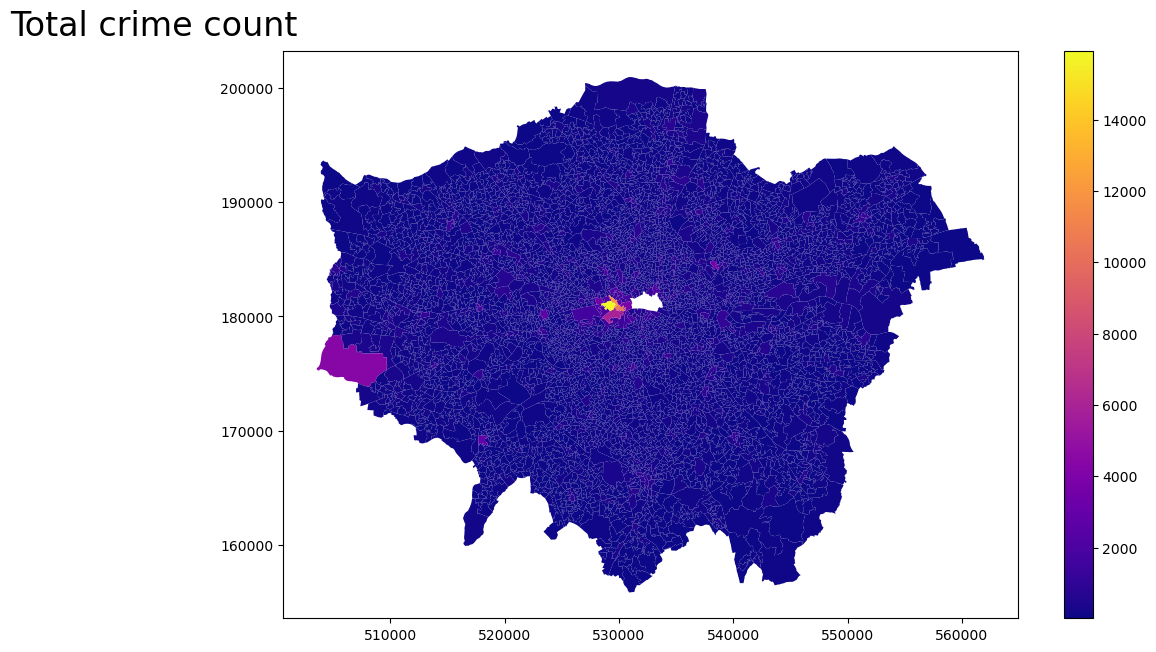

In [13]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
london_crime24.plot(column='Total_crime', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
# f.suptitle(f"{measure} House Prices (Raw)", x=0.025, size=24, **tfont);
f.suptitle(f"Total crime count", x=0.025, size=24);
plt.savefig('Total_crime_count.png', dpi=150)

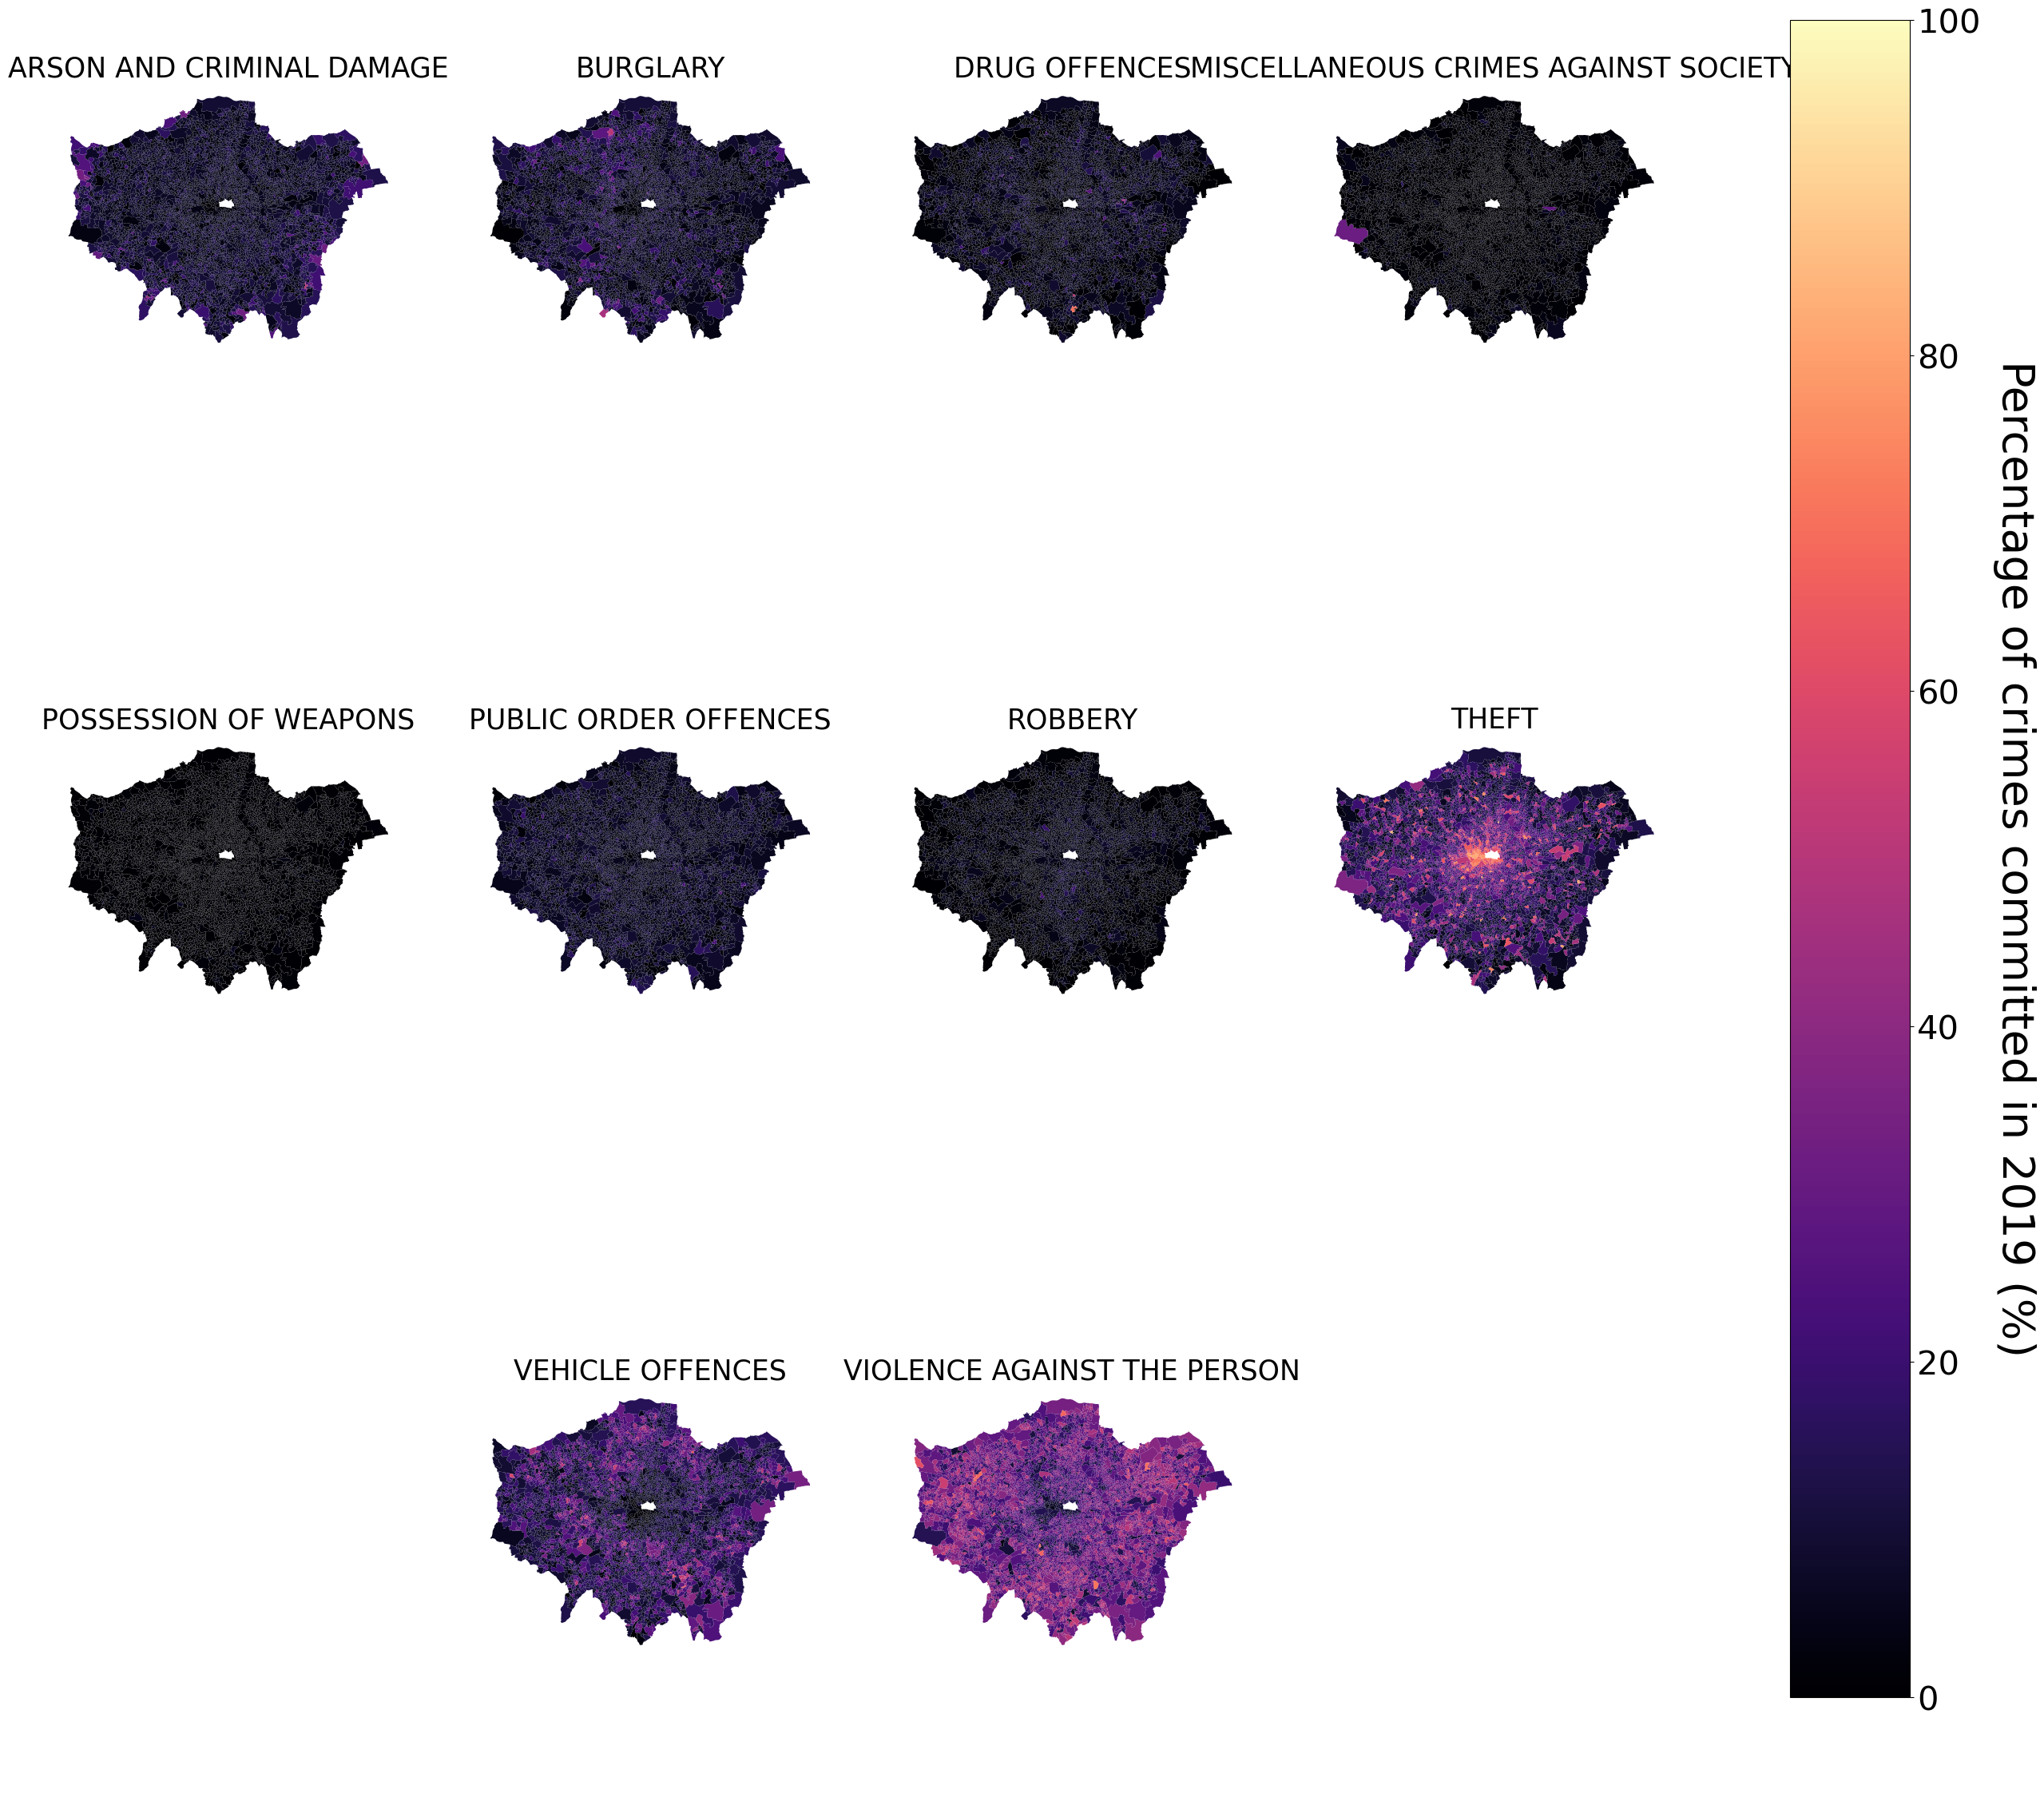

In [24]:
not_plot = ["lsoa21cd", "lsoa21nm", "geometry", "LSOA Code", "Total_crime"]
to_plot = [col for col in london_crime24 if col not in not_plot]

fig, axis = plt.subplots(3,4,figsize=(30,30))
#flatten the axis so that we can iterate over them
axis = axis.flatten()

for i, col in enumerate(to_plot):
    #set the axis as in the rows
    ax = axis[i]
    #to make it cleaner move two axis across
    if i >=8:
        ax = axis[i+1]
    #plot the crime map using the magma color map
    crim_plt = london_crime24.plot(column = col, ax=ax, cmap = "magma", vmin =0, vmax = 1)
    #remove the axis so that it looks cleaner
    ax.set_axis_off()
    #set the plot title as the column name
    ax.set_title(col, fontsize = 25)

vmin, vmax = 0, 100
#create a subaxis within the figure
fig = ax.get_figure()
plt.subplots_adjust(right = 0.8)
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7], label = "Percentage of crime")
#create a colorbar and plot it
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = fig.colorbar(sm, cax=cax)
#change the size of the tick parameters
cb.ax.tick_params(labelsize = 30)
#set the label title
#https://stackoverflow.com/questions/17475619/how-do-i-adjust-offset-colorbar-title-in-matplotlib
cb.set_label("Percentage of crimes committed in 2019 (%)", rotation = 270, fontsize= 40, labelpad = 50)
#
#cax.tight_layout()

#remove axis of plots not covered
axis[8].set_axis_off()
axis[11].set_axis_off()
#show the results
plt.show()

In [99]:
columns_list = london_crime24.columns.difference(['lsoa21cd', 'lsoa21nm', 'geometry']).tolist()
print(columns_list)

['ARSON AND CRIMINAL DAMAGE', 'BURGLARY', 'DRUG OFFENCES', 'MISCELLANEOUS CRIMES AGAINST SOCIETY', 'POSSESSION OF WEAPONS', 'PUBLIC ORDER OFFENCES', 'ROBBERY', 'THEFT', 'Total_crime', 'VEHICLE OFFENCES', 'VIOLENCE AGAINST THE PERSON', 'cluster_nm']


In [26]:
raw = london_crime24[london_crime24.columns.difference(['lsoa21nm', 'geometry', 'Total_crime'])].set_index('lsoa21cd').copy()
raw.head()

ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
lsoa21cd                                                        
E01000006                     0.0562    0.0225         0.0337   
E01000007                     0.0614    0.0422         0.1209   
E01000008                     0.0741    0.0296         0.0444   
E01000009                     0.0988    0.0494         0.0617   
E01000011                     0.0957    0.0435         0.0696   

           MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
lsoa21cd                                                                 
E01000006                                0.0225                 0.0225   
E01000007                                0.0038                 0.0077   
E01000008                                0.0000                 0.0000   
E01000009                                0.0123                 0.0082   
E01000011                                0.0348                 0.0000   

           PUBLIC ORDER OFFENCES  ROBBERY   THEFT  VEHICLE OFFENCES  \
lsoa21cd                                                              
E01000006                 0.0674   0.0674  0.1461            0.2360   
E01000007                 0.0806   0.0883  0.2649            0.0307   
E01000008                 0.0519   0.0444  0.1407            0.1630   
E01000009                 0.0494   0.0576  0.2387            0.0905   
E01000011                 0.0435   0.0435  0.1304            0.0696   

           VIOLENCE AGAINST THE PERSON  
lsoa21cd                                
E01000006                       0.3258  
E01000007                       0.2994  
E01000008                       0.4519  
E01000009                       0.3333  
E01000011                       0.4696

你使用了 **`RobustScaler(quantile_range=(10.0, 90.0))`**，这意味着你正在使用 **IQR（四分位数间距）缩放**，但自定义了 **分位数范围**。  

---

### **📌 规范化规则**
默认情况下，`RobustScaler()` 使用的是 **IQR（Interquartile Range，四分位数间距）**，即：
$$ X' = \frac{X - Q_2}{Q_3 - Q_1} $$
其中：
- \( Q_1 \)（第 25% 分位数）
- \( Q_2 \)（第 50% 分位数，即中位数）
- \( Q_3 \)（第 75% 分位数）

但在 **`quantile_range=(10.0, 90.0)`** 的情况下：
- **10% 分位数**（`Q_{10}`）替代了 `Q1`
- **90% 分位数**（`Q_{90}`）替代了 `Q3`

所以新的缩放公式变成：
$$ X' = \frac{X - Q_{50}}{Q_{90} - Q_{10}} $$

---
### **📌 这样做的影响**
1. **减少极端异常值的影响**：
   - 默认的 `RobustScaler()` 依赖 **25%~75%** 范围（IQR），对异常值已经不敏感。
   - 你现在用了 **10%~90%** 范围，会更进一步**减少对极端异常值的影响**。

2. **数据可能不会在 `[-1,1]` 之间**：
   - `RobustScaler` 不是 `MinMaxScaler()`，它不会固定缩放范围。
   - 结果数据的分布取决于原始数据的分布。

### **📌 适用场景**
- **当数据包含极端异常值（outliers）时**，可以调整 `quantile_range` 来减少它们的影响。
- **如果数据集的四分位范围较窄（25%-75%变化不大）**，可以适当扩展 `quantile_range`。

---
### **🚀 总结**
✅ **`RobustScaler(quantile_range=(10.0, 90.0))`** 依旧是基于中位数的缩放，但**减少了异常值的影响**。  
✅ 比默认的 **25%-75%** IQR 处理更加稳健，适合包含**极端值**的数据集。

In [28]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [29]:
normed = raw.copy()
for c in raw.columns.values:
  normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
  print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))

normed.head()

The range of ARSON AND CRIMINAL DAMAGE is [-0.7547663943012777, 4.6286402681751495]
The range of BURGLARY is [-0.6290812103375334, 3.969465648854962]
The range of DRUG OFFENCES is [-0.4868729200049304, 8.174534697399237]
The range of MISCELLANEOUS CRIMES AGAINST SOCIETY is [-0.33673469387755106, 10.455782312925171]
The range of POSSESSION OF WEAPONS is [0.0, 4.289308176100628]
The range of PUBLIC ORDER OFFENCES is [-0.7865535248041775, 2.6951697127937337]
The range of ROBBERY is [-0.43632987776574333, 3.1347671360049505]
The range of THEFT is [-0.5242593888500116, 1.9678679729414508]
The range of VEHICLE OFFENCES is [-0.6158940397350993, 2.2097130242825602]
The range of VIOLENCE AGAINST THE PERSON is [-0.9995245583878869, 1.491789489083129]


ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
lsoa21cd                                                        
E01000006                  -0.166038 -0.422147      -0.071490   
E01000007                  -0.111565 -0.240964       1.003328   
E01000008                   0.021475 -0.356847       0.060397   
E01000009                   0.280222 -0.174745       0.273635   
E01000011                   0.247748 -0.229008       0.371009   

           MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
lsoa21cd                                                                 
E01000006                              0.428571               1.415094   
E01000007                             -0.207483               0.484277   
E01000008                             -0.336735               0.000000   
E01000009                              0.081633               0.515723   
E01000011                              0.846939               0.000000   

           PUBLIC ORDER OFFENCES   ROBBERY     THEFT  VEHICLE OFFENCES  \
lsoa21cd                                                                 
E01000006               0.093342  0.606529 -0.098262          0.426049   
E01000007               0.265666  0.929909  0.248134         -0.480353   
E01000008              -0.109008  0.250658 -0.114007          0.103753   
E01000009              -0.141645  0.454897  0.171740         -0.216336   
E01000011              -0.218668  0.236732 -0.144040         -0.308609   

           VIOLENCE AGAINST THE PERSON  
lsoa21cd                                
E01000006                     0.073876  
E01000007                    -0.022675  
E01000008                     0.535055  
E01000009                     0.101306  
E01000011                     0.599788

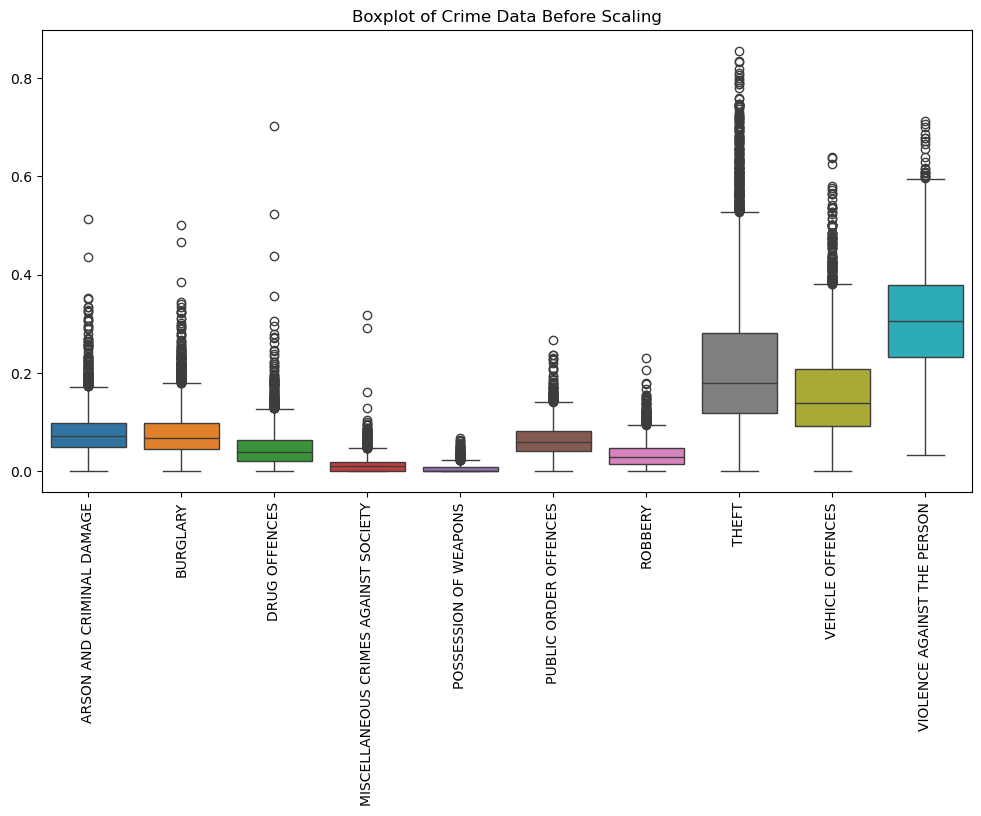

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=raw)
plt.xticks(rotation=90)
plt.title("Boxplot of Crime Data Before Scaling")
plt.show()


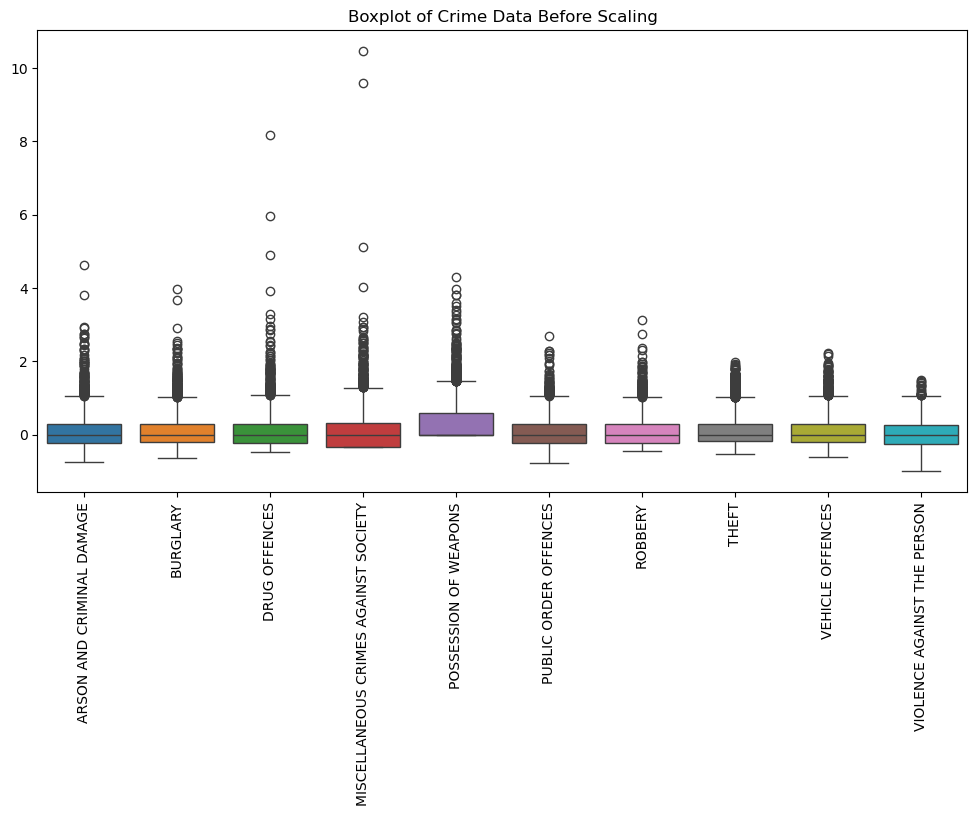

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=normed)
plt.xticks(rotation=90)
plt.title("Boxplot of Crime Data Before Scaling")
plt.show()


In [ ]:
# def mapping_clusters(labels_cluster):
#     crime24['cluster_nm'] = labels_cluster
#     crime24.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');


def mapping_clusters(labels_cluster):
	london_crime24['cluster_nm'] = labels_cluster
	london_crime24.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired')


In [37]:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    # 获取 DataFrame 的列名，即不同的变量（categories）。
    # 为了封闭雷达图，将第一个类别添加到列表末尾，使得曲线能回到起点。

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    # 计算 各个变量在极坐标中的角度，确保它们等间距分布在 [0, 2π] 之间
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
        # 遍历 df_cluster_centroid 的每一行（每个聚类中心）。
        # 将该行转换为 list，并封闭曲线（把第一个值追加到末尾）。
        # 用 plt.plot() 在极坐标中画出该聚类中心的雷达图曲线。
        # 设置标签，如 "Cluster 0", "Cluster 1"。

    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

## DBSCAN

So, let's run the DBSCAN clustering method. According to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), the model can take a number of parameters: the `eps` distance and `min_samples` group size attributes are fundamental in creating the clusters. I've suggested some values below, but we'll try amending those later.

### First DBSCAN

In [32]:
raw.shape

(4988, 10)

In [42]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4988 entries, E01000006 to E01035722
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ARSON AND CRIMINAL DAMAGE             4988 non-null   float64
 1   BURGLARY                              4988 non-null   float64
 2   DRUG OFFENCES                         4988 non-null   float64
 3   MISCELLANEOUS CRIMES AGAINST SOCIETY  4988 non-null   float64
 4   POSSESSION OF WEAPONS                 4988 non-null   float64
 5   PUBLIC ORDER OFFENCES                 4988 non-null   float64
 6   ROBBERY                               4988 non-null   float64
 7   THEFT                                 4988 non-null   float64
 8   VEHICLE OFFENCES                      4988 non-null   float64
 9   VIOLENCE AGAINST THE PERSON           4988 non-null   float64
dtypes: float64(10)
memory usage: 557.7+ KB


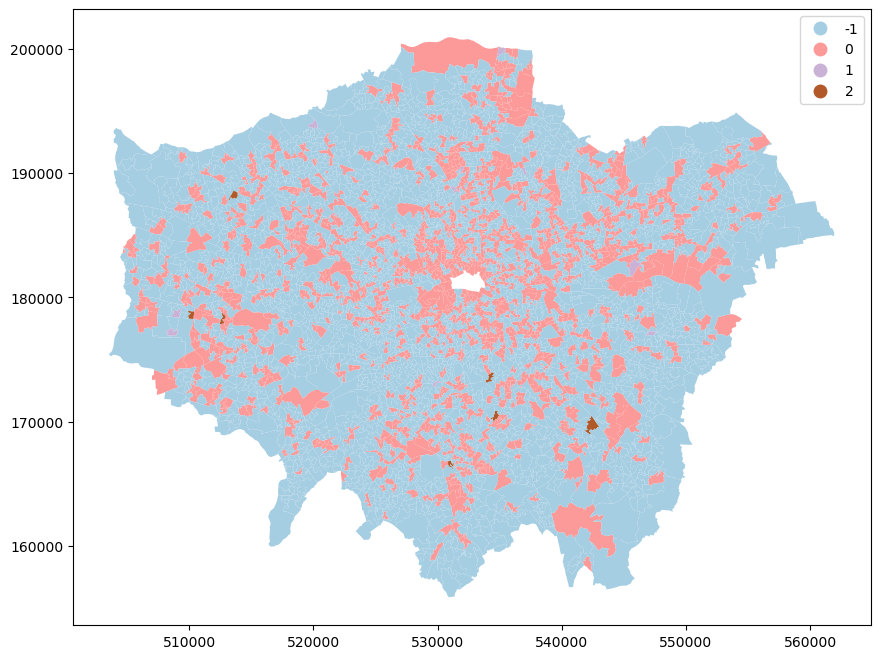

In [64]:
minPts = 11 # we set minPts as normed.shape[1] + 1 
epsilon = 0.05 # eps 决定了核心点（Core Point）的搜索半径。
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(raw)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_

mapping_clusters(cluster_nm)

In [59]:
pd.Series(dbsc.labels_).value_counts()

-1    3498
 0    1473
 1      10
 2       7
Name: count, dtype: int64

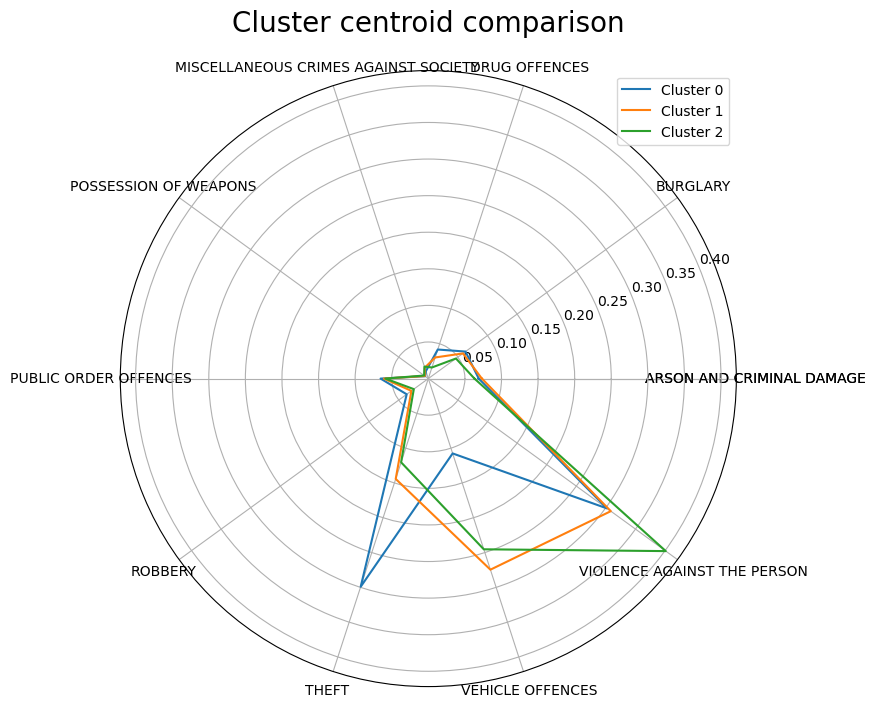

In [65]:
df_dbscan = raw.copy()
df_dbscan['cluster'] = dbsc.labels_
df_dbscan_centroid = df_dbscan.groupby('cluster').mean()
# drop the outlier
df_dbscan_centroid.drop(-1, inplace=True)
# df_dbscan_centroid.reset_index()
radar_plot_cluster_centroids(df_dbscan_centroid)

In [66]:
from sklearn import metrics
metrics.silhouette_score(raw, dbsc.labels_)

-0.2281686931181071

## KMeans

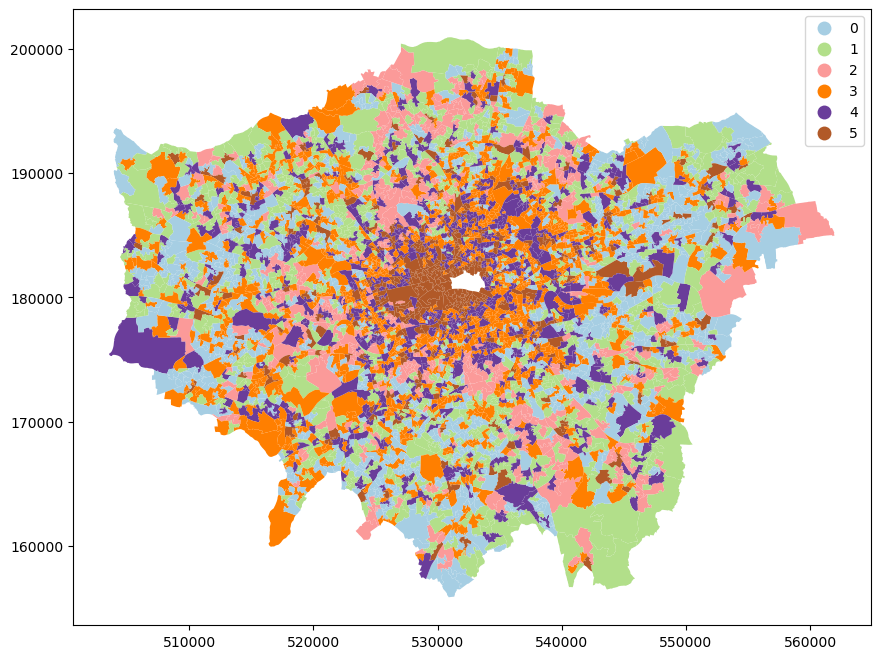

In [122]:
k_cluster = 6
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster, random_state=random_seed)
kmeans_method.fit(raw)
mapping_clusters(kmeans_method.labels_)

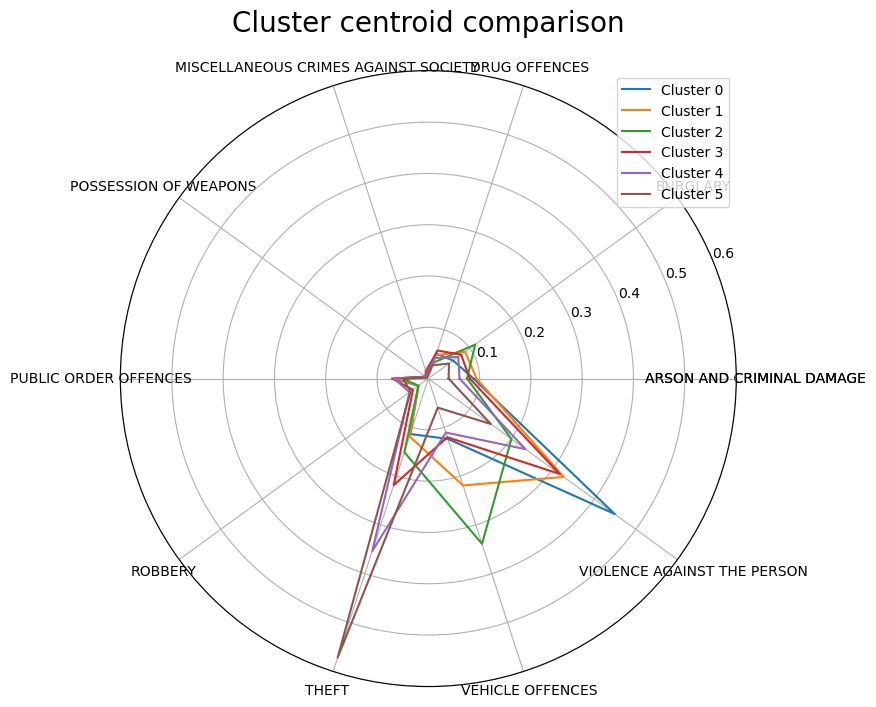

In [123]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=raw.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

### Randomness of K-Means

K-Means involves randomness. The parameter of **random_state** controls the initialisation of the cluster centroids. If you change the value of random_state, the initial centroids will be different and you will probably get a different clustering. If you don't specify the random_state in the code, then every time you execute your code a new random value is generated and the train and test datasets would have different values each time.

The reason for setting the random_state here is to reproduce the result. But in real-world projects, you are not encouraged to manipulate the result via testing with different random_state values.

A common practice with K-Means (and other algorithms involving randomness) is to run the algorithm many times using different random seeds and then choose the best result, such as the result with the lowest SSE. In the sklearn K-Means function, the parameter of **n_init** (default at 10) specifies the number of times the K-Means algorithm will be run with different centroid seeds. The final result will be the best output of **n_init** runs in terms of inertia (aka, SSE).

Read more about K-Means in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

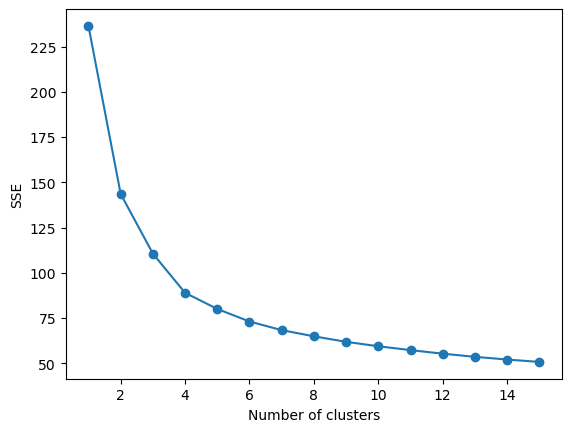

In [73]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 15
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(raw)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

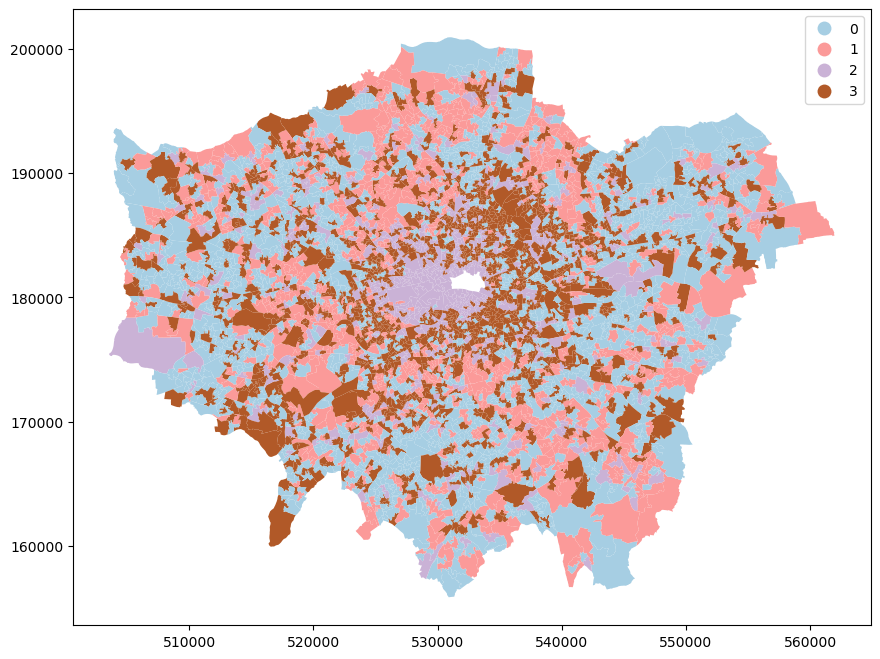

In [124]:
k_cluster = 4
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster, random_state=random_seed)
kmeans_method.fit(raw)

# plotting
mapping_clusters(kmeans_method.labels_);

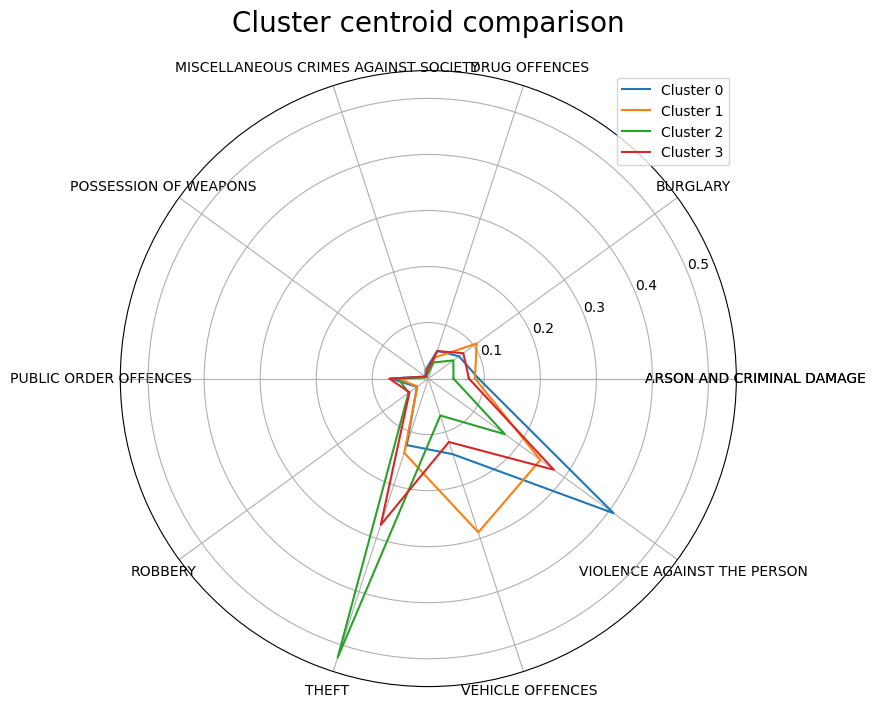

In [125]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=raw.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

## Hierarchical clustering

We will test the Agglomerative Clustering (one type of hierarchical clustering) for this dataset. 

First, we will generate and plot the dendrogram from the clustering process. This shows the hierarchy of the clusters.

Given the hundreds of data points, the whole dendrogram starting from the individual level would be complicated and challenging to visualise. Therefore, we will show the top three levels of the dendrogram. 

The code of **plot_dendrogram** is largely based on this [tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py). More details about the dendrogram function from scipy is [here](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.cluster.hierarchy.dendrogram.html?highlight=dendrogram#scipy.cluster.hierarchy.dendrogram).

In [78]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

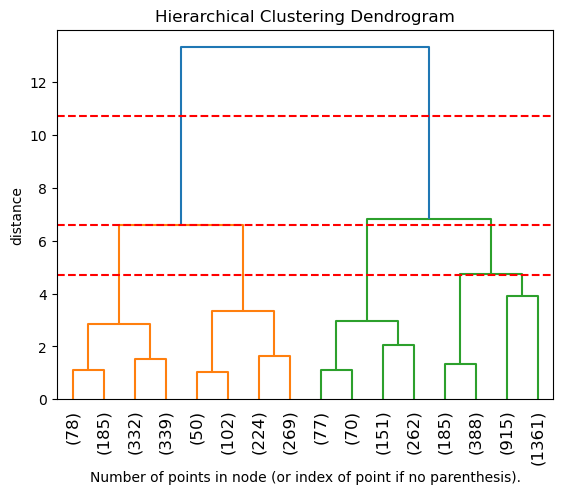

In [83]:
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(raw)
ax = plt.gca()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
# note that these two red dashed lines are drawn manually, as we see that the gap between the two lines is larger than other gaps
plt.hlines(10.7, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.hlines(6.6, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.hlines(4.7, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.show()

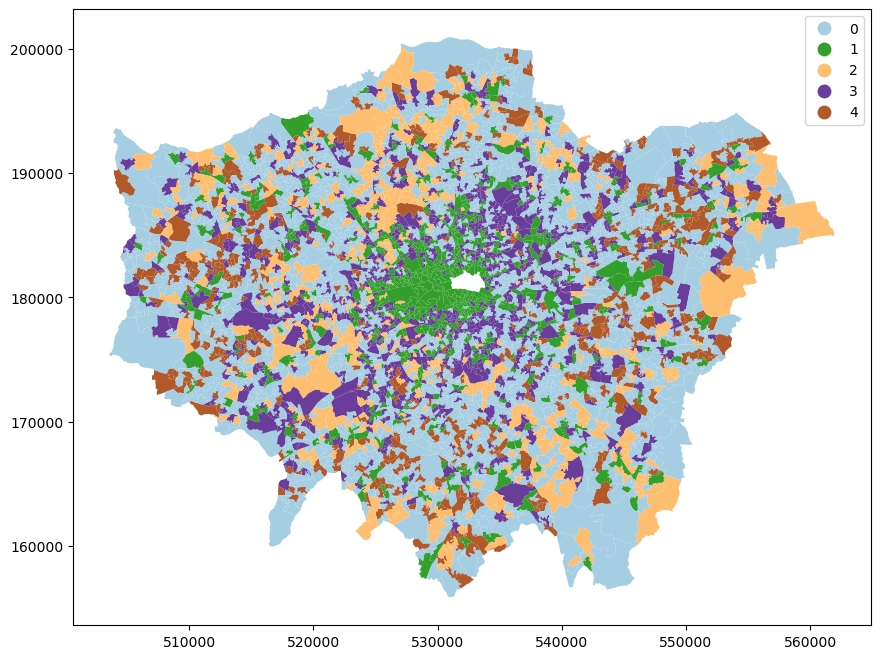

In [85]:
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=5).fit(raw)
mapping_clusters(agg_cluster.labels_)

In [86]:
pd.Series(agg_cluster.labels_).value_counts()

0    2276
3     934
1     645
4     573
2     560
Name: count, dtype: int64

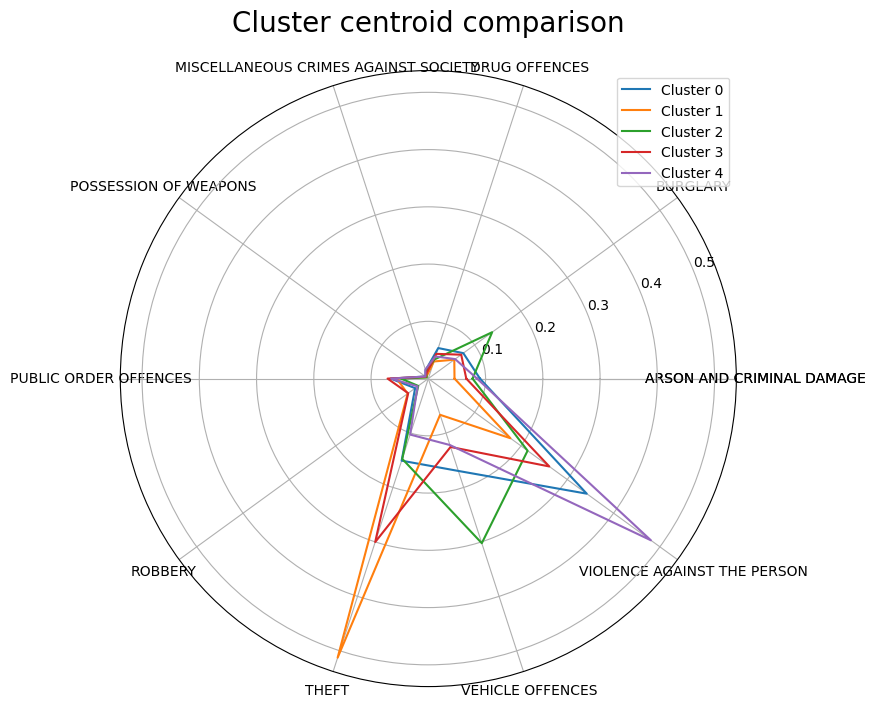

In [88]:
df_cluster_centroid = raw.copy()
df_cluster_centroid['cluster'] = agg_cluster.labels_
df_cluster_centroid = df_cluster_centroid.groupby('cluster').mean()
radar_plot_cluster_centroids(df_cluster_centroid)

## Regionalisation: max-p problem

The clusters generated by DBSCAN/Kmeans/Hierarchical clustering methods are not spatially contiguous. In other words, a cluster is very likely to contain LSOAs that are not spatially connected.

Spatially constrained clustering, also called regionalisation, have been proposed to derive spatially contiguous clusters.

One such method is the max-p problem. It aims to generate a maximum number of clusters conditioning that:

1. Each cluster is spatially contiguous. In other words, each cluster is a 'region';
2. The sum of a variable (e.g. population or number of spatial units) of each cluster is above a predefined threshold value. For example, the accumulative population of each cluster is above 10% of the total population, or the number of spatial units in each cluster is above 20% of the total spatial units.

Note that the number of clusters generated by the max-p method is not predefined; it is automatically determined by the algorithm.

This section is based on this [tutorial](https://pysal.org/spopt/notebooks/maxp.html).

Preparation:

In [89]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

In [100]:
london_crime24.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   lsoa21cd                              4988 non-null   object  
 1   lsoa21nm                              4988 non-null   object  
 2   geometry                              4988 non-null   geometry
 3   ARSON AND CRIMINAL DAMAGE             4988 non-null   float64 
 4   BURGLARY                              4988 non-null   float64 
 5   DRUG OFFENCES                         4988 non-null   float64 
 6   MISCELLANEOUS CRIMES AGAINST SOCIETY  4988 non-null   float64 
 7   POSSESSION OF WEAPONS                 4988 non-null   float64 
 8   PUBLIC ORDER OFFENCES                 4988 non-null   float64 
 9   ROBBERY                               4988 non-null   float64 
 10  THEFT                                 4988 non-null   float64 
 

In [101]:
london_crime24.lsoa21nm.str.contains('Camden')

0       False
1       False
2       False
3       False
4       False
        ...  
4983    False
4984    False
4985    False
4986    False
4987    False
Name: lsoa21nm, Length: 4988, dtype: bool

In [102]:
camden_msoa = london_crime24[london_crime24.lsoa21nm.str.contains('Camden')]
camden_raw = raw.iloc[london_crime24.lsoa21nm.str.contains('Camden').tolist()]
camden_msoa.shape

(130, 15)

In [105]:
attrs_name = camden_raw.columns.values.tolist()
attrs_name

['ARSON AND CRIMINAL DAMAGE',
 'BURGLARY',
 'DRUG OFFENCES',
 'MISCELLANEOUS CRIMES AGAINST SOCIETY',
 'POSSESSION OF WEAPONS',
 'PUBLIC ORDER OFFENCES',
 'ROBBERY',
 'THEFT',
 'VEHICLE OFFENCES',
 'VIOLENCE AGAINST THE PERSON']

In [106]:
w = libpysal.weights.Queen.from_dataframe(camden_msoa)

In [108]:
threshold = 0.2 * camden_raw.shape[0]
print(threshold)
camden_raw_copy = camden_raw.copy()
camden_raw_copy["count"] = 1
threshold_name = "count"

26.0


In [109]:
camden_raw_copy

ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
lsoa21cd                                                        
E01000842                     0.0490    0.1373         0.0098   
E01000843                     0.0870    0.1449         0.0290   
E01000844                     0.0550    0.1284         0.0459   
E01000845                     0.0590    0.0443         0.0074   
E01000846                     0.0282    0.1127         0.0845   
...                              ...       ...            ...   
E01035708                     0.0255    0.0247         0.0088   
E01035709                     0.0379    0.0521         0.1090   
E01035710                     0.0234    0.0301         0.0250   
E01035711                     0.0278    0.0250         0.0075   
E01035712                     0.0750    0.0300         0.0800   

           MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
lsoa21cd                                                                 
E01000842                                0.0000                 0.0000   
E01000843                                0.0000                 0.0000   
E01000844                                0.0092                 0.0000   
E01000845                                0.0074                 0.0000   
E01000846                                0.0000                 0.0000   
...                                         ...                    ...   
E01035708                                0.0032                 0.0016   
E01035709                                0.0047                 0.0190   
E01035710                                0.0050                 0.0017   
E01035711                                0.0024                 0.0019   
E01035712                                0.0100                 0.0050   

           PUBLIC ORDER OFFENCES  ROBBERY   THEFT  VEHICLE OFFENCES  \
lsoa21cd                                                              
E01000842                 0.0490   0.0392  0.2255            0.2647   
E01000843                 0.0580   0.0000  0.2754            0.1594   
E01000844                 0.0275   0.0826  0.3394            0.2202   
E01000845                 0.0185   0.0664  0.6347            0.0480   
E01000846                 0.0423   0.0141  0.2254            0.1127   
...                          ...      ...     ...               ...   
E01035708                 0.0446   0.0446  0.6550            0.0566   
E01035709                 0.0806   0.0806  0.2986            0.0806   
E01035710                 0.0451   0.0384  0.6010            0.0434   
E01035711                 0.0547   0.0363  0.6828            0.0118   
E01035712                 0.0550   0.0450  0.3900            0.0300   

           VIOLENCE AGAINST THE PERSON  count  
lsoa21cd                                       
E01000842                       0.2255      1  
E01000843                       0.2464      1  
E01000844                       0.0917      1  
E01000845                       0.1144      1  
E01000846                       0.3803      1  
...                                ...    ...  
E01035708                       0.1355      1  
E01035709                       0.2370      1  
E01035710                       0.1870      1  
E01035711                       0.1499      1  
E01035712                       0.2800      1  

[130 rows x 11 columns]

Max-P 问题的核心思想

目标：在空间上创建尽可能多的区域 𝑃，使得每个区域内部满足某个最小阈值（例如人口、经济水平等）。

约束条件：
- 区域内属性（如人口）必须超过一个阈值（如人口 > 5000）。
- 区域必须是空间连通的（所有区域必须是相邻的，不能出现“飞地”）。
- 合并后区域内部尽量相似（基于某些统计指标，如均值或方差）。
- 
Max-P 方法不同于 K-Means 或 DBSCAN 这种纯粹的点聚类算法，它更适合地理空间数据的分区，例如：
- 将伦敦的街区划分成更大的功能区。
- 识别城市中的经济、社会或环境分区。

In [112]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(camden_raw_copy, w, attrs_name, threshold_name, threshold, top_n=5)
# top_n=3：这个参数告诉模型返回 最优的3个结果，即模型会选择最符合优化标准的前三个区域。
model.solve()

CPU times: total: 1min 59s
Wall time: 12min 9s


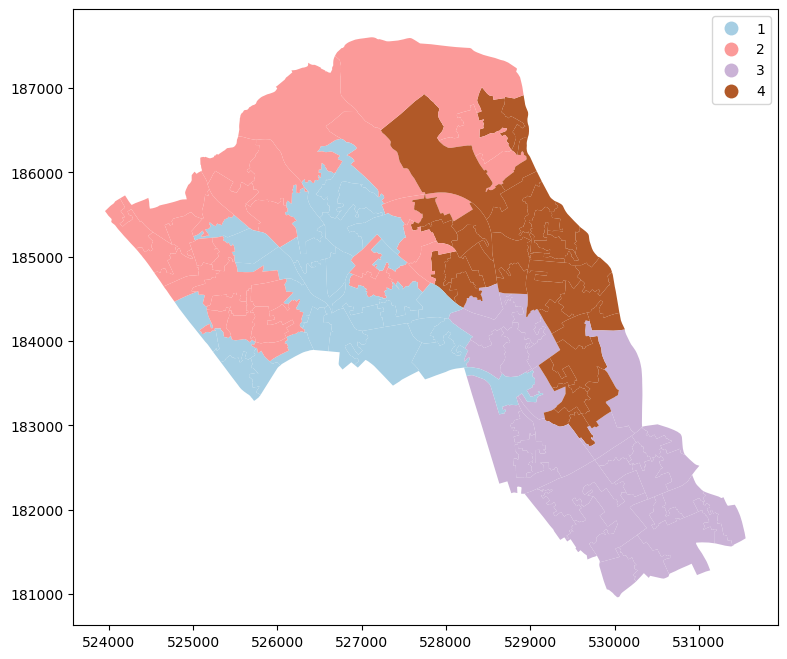

In [113]:
camden_msoa['cluster_max_p'] = model.labels_
# 将 MaxP 模型的标签（即每个区域的聚类标签）赋值给 camden_msoa 数据集中的新列

camden_msoa.plot(column='cluster_max_p', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [ ]:
df_cluster_centroid = raw.copy()
df_cluster_centroid['cluster'] = agg_cluster.labels_
df_cluster_centroid = df_cluster_centroid.groupby('cluster').mean()
radar_plot_cluster_centroids(df_cluster_centroid)

In [120]:
camden_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, E01000842 to E01035712
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ARSON AND CRIMINAL DAMAGE             130 non-null    float64
 1   BURGLARY                              130 non-null    float64
 2   DRUG OFFENCES                         130 non-null    float64
 3   MISCELLANEOUS CRIMES AGAINST SOCIETY  130 non-null    float64
 4   POSSESSION OF WEAPONS                 130 non-null    float64
 5   PUBLIC ORDER OFFENCES                 130 non-null    float64
 6   ROBBERY                               130 non-null    float64
 7   THEFT                                 130 non-null    float64
 8   VEHICLE OFFENCES                      130 non-null    float64
 9   VIOLENCE AGAINST THE PERSON           130 non-null    float64
 10  cluster_max_p                         130 non-null    int64  
dtypes: float64

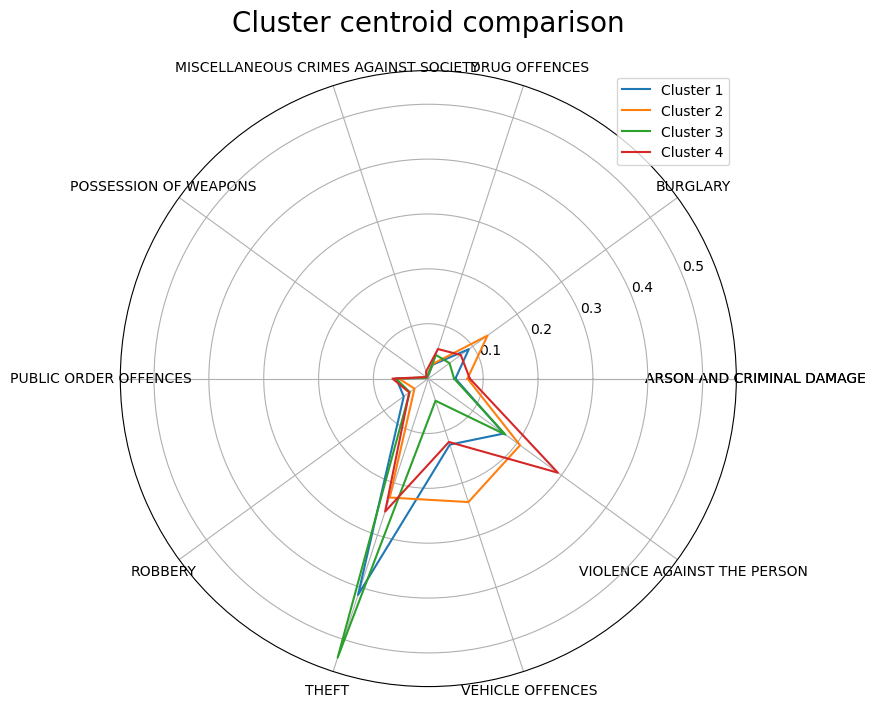

In [121]:
camden_raw['cluster_max_p'] = model.labels_
df_cluster_centroid = camden_raw.groupby('cluster_max_p').mean()
radar_plot_cluster_centroids(df_cluster_centroid)

In [127]:
london_crime24

lsoa21cd                   lsoa21nm  \
0     E01000006  Barking and Dagenham 016A   
1     E01000007  Barking and Dagenham 015A   
2     E01000008  Barking and Dagenham 015B   
3     E01000009  Barking and Dagenham 016B   
4     E01000011  Barking and Dagenham 016C   
...         ...                        ...   
4983  E01035718           Westminster 019G   
4984  E01035719           Westminster 021F   
4985  E01035720           Westminster 021G   
4986  E01035721           Westminster 023H   
4987  E01035722           Westminster 024G   

                                               geometry  \
0     POLYGON ((545126.852 184310.838, 545145.213 18...   
1     POLYGON ((544173.015 184701.354, 544180.164 18...   
2     POLYGON ((543570.116 184563.91, 543581.835 184...   
3     POLYGON ((544602.706 184628.237, 544605.228 18...   
4     POLYGON ((544607.954 184727.846, 544620.667 18...   
...                                                 ...   
4983  POLYGON ((528044.949 180617.984, 528046.344 18...   
4984  POLYGON ((530383.75 178784.828, 530376.55 1787...   
4985  POLYGON ((529856.151 178761.747, 529856.859 17...   
4986  POLYGON ((528641.815 178630.886, 528635.688 17...   
4987  POLYGON ((529606.362 178302.445, 529606.641 17...   

      ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
0                        0.0562    0.0225         0.0337   
1                        0.0614    0.0422         0.1209   
2                        0.0741    0.0296         0.0444   
3                        0.0988    0.0494         0.0617   
4                        0.0957    0.0435         0.0696   
...                         ...       ...            ...   
4983                     0.0369    0.0137         0.0584   
4984                     0.0645    0.0215         0.0430   
4985                     0.0366    0.0610         0.0122   
4986                     0.0546    0.0375         0.0188   
4987                     0.0429    0.1214         0.0571   

      MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
0                                   0.0225                 0.0225   
1                                   0.0038                 0.0077   
2                                   0.0000                 0.0000   
3                                   0.0123                 0.0082   
4                                   0.0348                 0.0000   
...                                    ...                    ...   
4983                                0.0024                 0.0042   
4984                                0.0000                 0.0000   
4985                                0.0122                 0.0122   
4986                                0.0051                 0.0017   
4987                                0.0143                 0.0143   

      PUBLIC ORDER OFFENCES  ROBBERY   THEFT  VEHICLE OFFENCES  \
0                    0.0674   0.0674  0.1461            0.2360   
1                    0.0806   0.0883  0.2649            0.0307   
2                    0.0519   0.0444  0.1407            0.1630   
3                    0.0494   0.0576  0.2387            0.0905   
4                    0.0435   0.0435  0.1304            0.0696   
...                     ...      ...     ...               ...   
4983                 0.0566   0.0501  0.5131            0.1210   
4984                 0.0753   0.0645  0.3548            0.0323   
4985                 0.0854   0.0366  0.3659            0.0976   
4986                 0.0444   0.0427  0.5597            0.0392   
4987                 0.0929   0.0429  0.3357            0.0429   

      VIOLENCE AGAINST THE PERSON  Total_crime  cluster_nm  
0                          0.3258           89           1  
1                          0.2994          521           3  
2                          0.4519          135           0  
3                          0.3333          243           3  
4                          0.4696          115           0  
...                           ...   

### Getis-Ord G 统计分析*
目标：找出 统计上显著 的高值（热点）和低值（冷点）。

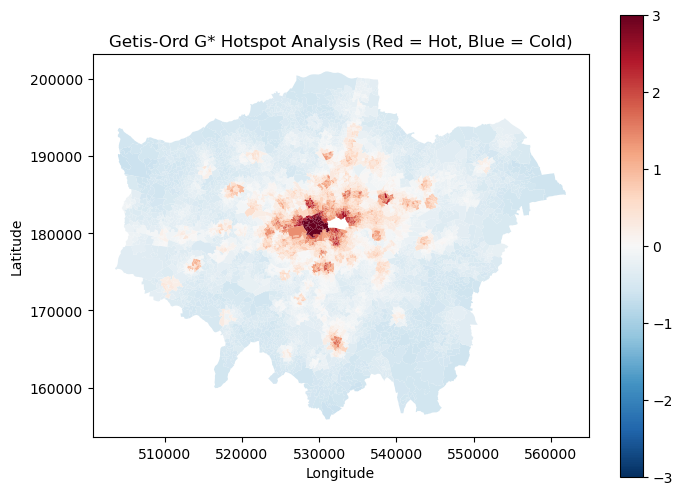

In [142]:
import esda

# 读取数据
crime_gdf = london_crime24.copy()  # 确保不修改原数据

# 计算犯罪率
crime_gdf["crime_rate"] = crime_gdf["Total_crime"] / crime_gdf.area  # 计算单位面积犯罪率

# 计算空间权重矩阵（邻近 LSOA）
w = libpysal.weights.KNN.from_dataframe(crime_gdf, k=8)  # 8 近邻
w.transform = "R"  # 归一化权重

# 计算 Getis-Ord G*
g_star = esda.G_Local(crime_gdf["crime_rate"], w)

# 存储 G* 值
crime_gdf["g_star"] = g_star.Zs  # 标准化 Z 值（Z-score）

# 设定颜色（符合 R 风格：红高蓝低）
fig, ax = plt.subplots(figsize=(8, 6))
crime_gdf.plot(
  column="g_star", cmap="RdBu_r", edgecolor="black", linewidth=0,
  legend=True, ax=ax, vmin=-3, vmax=3  # 限制范围使颜色更明显
)

# 美化图表
plt.title("Getis-Ord G* Hotspot Analysis (Red = Hot, Blue = Cold)", fontsize=12)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


In [144]:
crime_gdf.head()

lsoa21cd                   lsoa21nm  \
0  E01000006  Barking and Dagenham 016A   
1  E01000007  Barking and Dagenham 015A   
2  E01000008  Barking and Dagenham 015B   
3  E01000009  Barking and Dagenham 016B   
4  E01000011  Barking and Dagenham 016C   

                                            geometry  \
0  POLYGON ((545126.852 184310.838, 545145.213 18...   
1  POLYGON ((544173.015 184701.354, 544180.164 18...   
2  POLYGON ((543570.116 184563.91, 543581.835 184...   
3  POLYGON ((544602.706 184628.237, 544605.228 18...   
4  POLYGON ((544607.954 184727.846, 544620.667 18...   

   ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
0                     0.0562    0.0225         0.0337   
1                     0.0614    0.0422         0.1209   
2                     0.0741    0.0296         0.0444   
3                     0.0988    0.0494         0.0617   
4                     0.0957    0.0435         0.0696   

   MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
0                                0.0225                 0.0225   
1                                0.0038                 0.0077   
2                                0.0000                 0.0000   
3                                0.0123                 0.0082   
4                                0.0348                 0.0000   

   PUBLIC ORDER OFFENCES  ROBBERY   THEFT  VEHICLE OFFENCES  \
0                 0.0674   0.0674  0.1461            0.2360   
1                 0.0806   0.0883  0.2649            0.0307   
2                 0.0519   0.0444  0.1407            0.1630   
3                 0.0494   0.0576  0.2387            0.0905   
4                 0.0435   0.0435  0.1304            0.0696   

   VIOLENCE AGAINST THE PERSON  Total_crime  cluster_nm  crime_rate    g_star  \
0                       0.3258           89           1    0.000607  0.644571   
1                       0.2994          521           3    0.002604  0.892898   
2                       0.4519          135           0    0.000622  0.214865   
3                       0.3333          243           3    0.001899  0.741848   
4                       0.4696          115           0    0.001255  0.829727   

   hotspot  
0        4  
1        4  
2        3  
3        4  
4        4

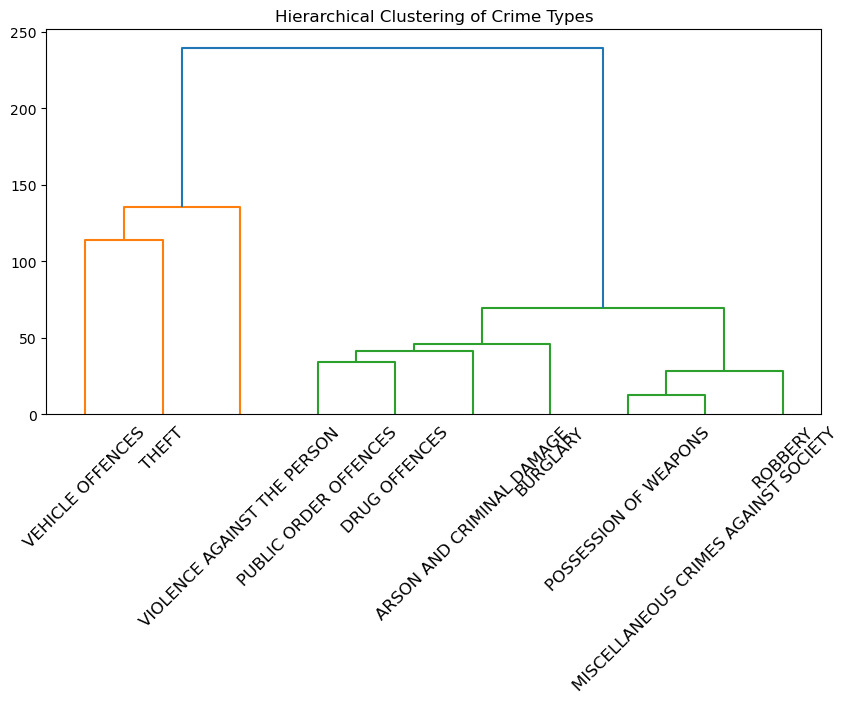

In [128]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 读取数据（确保数据是 DataFrame）
crime_df = london_crime24.copy()

# 选择犯罪类型数据（去掉非犯罪相关列）
crime_types = [
    "ARSON AND CRIMINAL DAMAGE", "BURGLARY", "DRUG OFFENCES",
    "MISCELLANEOUS CRIMES AGAINST SOCIETY", "POSSESSION OF WEAPONS",
    "PUBLIC ORDER OFFENCES", "ROBBERY", "THEFT",
    "VEHICLE OFFENCES", "VIOLENCE AGAINST THE PERSON"
]
crime_data = crime_df[crime_types]

# 数据标准化
scaler = StandardScaler()
crime_data_scaled = scaler.fit_transform(crime_data.T)  # **转置** 让行变为犯罪类型

# 计算距离矩阵
linked = sch.linkage(crime_data_scaled, method='ward')

# 绘制树状图
plt.figure(figsize=(10, 5))
sch.dendrogram(linked, labels=crime_types, orientation="top", distance_sort="descending")
plt.title("Hierarchical Clustering of Crime Types")
plt.xticks(rotation=45)
plt.show()


### XGBoost

In [153]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 选择特征（去掉非数值列）
X = london_crime24[cols_to_sum]
y = (london_crime24["Total_crime"] > crime_df["Total_crime"].quantile(0.8)).astype(int)  # 定义高风险（前 20%）

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练 XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# 预测
y_pred = xgb_model.predict(X_test)

# 评估模型
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))


XGBoost Accuracy: 0.9258517034068137


In [ ]:
%pip install shap

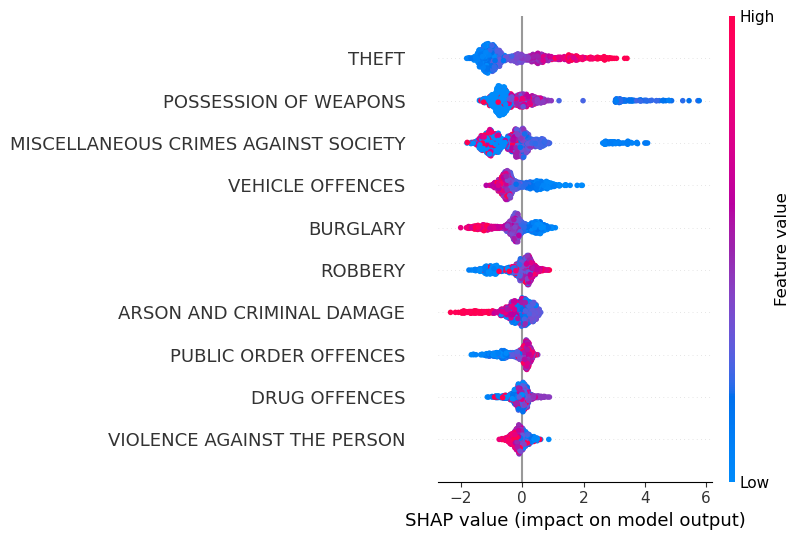

In [148]:
import shap

# 计算特征重要性
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# 绘制 SHAP 值
shap.summary_plot(shap_values, X_test)


### PCA

主成分贡献率: [0.22069293 0.16607612 0.10586137 0.09719445 0.09126082]


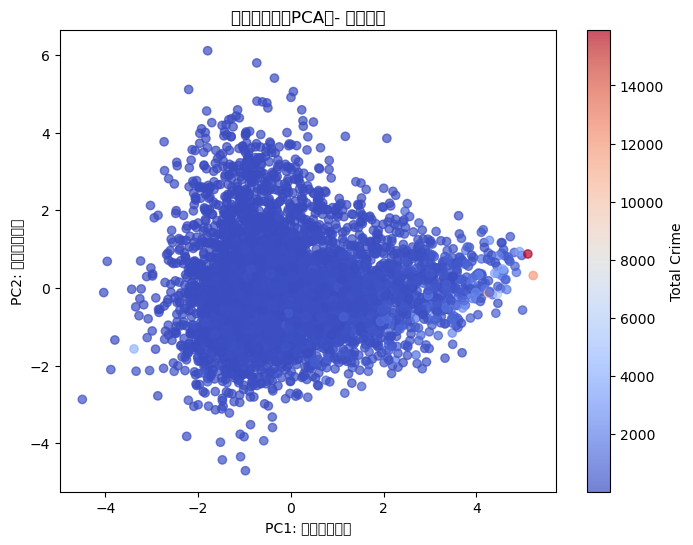

     ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
PC1                  -0.351797 -0.104394      -0.075172   
PC2                  -0.055876  0.487525      -0.298533   
PC3                  -0.194471  0.037735       0.626318   
PC4                  -0.010104 -0.388811      -0.273754   
PC5                   0.020209 -0.177708       0.473009   

     MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
PC1                             -0.252085              -0.065311   
PC2                             -0.070946              -0.272905   
PC3                              0.128592               0.446505   
PC4                              0.716452              -0.250107   
PC5                             -0.291242              -0.768435   

     PUBLIC ORDER OFFENCES   ROBBERY     THEFT  VEHICLE OFFENCES  \
PC1              -0.015497  0.382267  0.620287         -0.291463   
PC2              -0.366578 -0.133428  0.010406          0.529882   
PC3              -0.528964  0.18

In [155]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 选择犯罪类型数据（去掉非数值列）
crime_features = london_crime24[cols_to_sum]

# 标准化数据
scaler = StandardScaler()
crime_scaled = scaler.fit_transform(crime_features)

# 进行 PCA
pca = PCA(n_components=5)  # 选取前两个主成分
crime_pca = pca.fit_transform(crime_scaled)

# 查看主成分贡献率
print("主成分贡献率:", pca.explained_variance_ratio_)

# 可视化
plt.figure(figsize=(8, 6))
plt.scatter(crime_pca[:, 0], crime_pca[:, 1], c=london_crime24["Total_crime"], cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Total Crime")
plt.xlabel("PC1: 主要犯罪模式")
plt.ylabel("PC2: 次要犯罪模式")
plt.title("主成分分析（PCA）- 犯罪模式")
plt.show()

# 查看主成分对原始犯罪类型的贡献
pca_components = pd.DataFrame(pca.components_, columns=crime_features.columns, index=["PC1", "PC2", "PC3", "PC4", "PC5"])
print(pca_components)


### PCA + K-Means 聚类
📌 主要步骤

使用 PCA 降维：把 10 种犯罪类型降到 2~3 维

用 K-Means 聚类：基于主成分对 LSOA 进行聚类，发现不同犯罪模式

可视化结果：画出不同类别的 LSOA，看哪些地区的犯罪模式相似

In [176]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取数据（去掉非数值列）
crime_features = london_crime24[cols_to_sum]

# 归一化数据（标准化）
scaler = StandardScaler()
crime_scaled = scaler.fit_transform(crime_features)

# 运行 PCA，降维到 2 维
pca = PCA(n_components=4)
crime_pca = pca.fit_transform(crime_scaled)

# 转换成 DataFrame
crime_pca_df = pd.DataFrame(crime_pca, columns=["PC1", "PC2", "PC3", "PC4"])
crime_pca_df["lsoa21cd"] = london_crime24["lsoa21cd"]
crime_pca_df["lsoa21nm"] = london_crime24["lsoa21nm"]


In [177]:
print(pd.DataFrame(pca.components_, columns=crime_features.columns, index=["PC1", "PC2", "PC3", "PC4"]))

     ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
PC1                  -0.351797 -0.104394      -0.075172   
PC2                  -0.055876  0.487525      -0.298533   
PC3                  -0.194471  0.037735       0.626318   
PC4                  -0.010104 -0.388811      -0.273754   

     MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
PC1                             -0.252085              -0.065311   
PC2                             -0.070946              -0.272905   
PC3                              0.128592               0.446505   
PC4                              0.716452              -0.250107   

     PUBLIC ORDER OFFENCES   ROBBERY     THEFT  VEHICLE OFFENCES  \
PC1              -0.015497  0.382267  0.620287         -0.291463   
PC2              -0.366578 -0.133428  0.010406          0.529882   
PC3              -0.528964  0.184638 -0.074014          0.135872   
PC4              -0.396099  0.098911  0.148599         -0.011285   

     VIOLENCE AGAINST 

In [178]:
#查看 PC1 和 PC2 解释的数据比例
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.22069293 0.16607612 0.10586137 0.09719445]


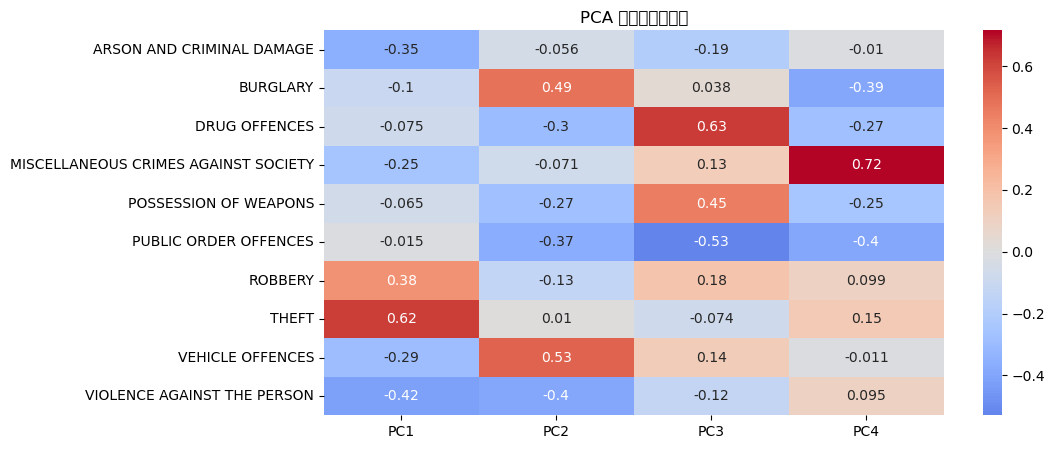

In [179]:
#画出犯罪类型的 PCA 贡献

# 获取主成分系数
pca_components = pd.DataFrame(pca.components_, columns=crime_features.columns, index=["PC1", "PC2", "PC3", "PC4"])

# 画热力图
plt.figure(figsize=(10, 5))
sns.heatmap(pca_components.T, annot=True, cmap="coolwarm", center=0)
plt.title("PCA 主成分负载矩阵")
plt.show()


In [180]:
# 选择聚类数（比如 4 类）
kmeans = KMeans(n_clusters=4, random_state=42)
crime_pca_df["cluster"] = kmeans.fit_predict(crime_pca)

# 把聚类标签加回原始 DataFrame
london_crime24["cluster_kmeans"] = crime_pca_df["cluster"]


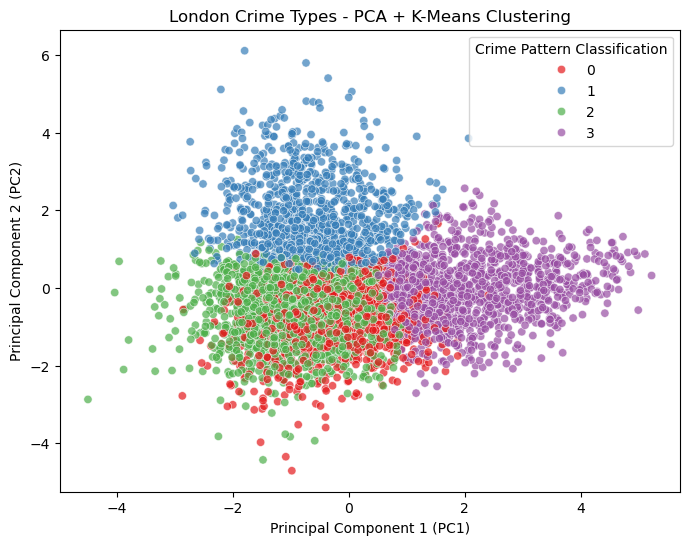

In [181]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=crime_pca_df["PC1"], y=crime_pca_df["PC2"], hue=crime_pca_df["cluster"], palette="Set1", alpha=0.7)
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("London Crime Types - PCA + K-Means Clustering")
plt.legend(title="Crime Pattern Classification")
plt.show()


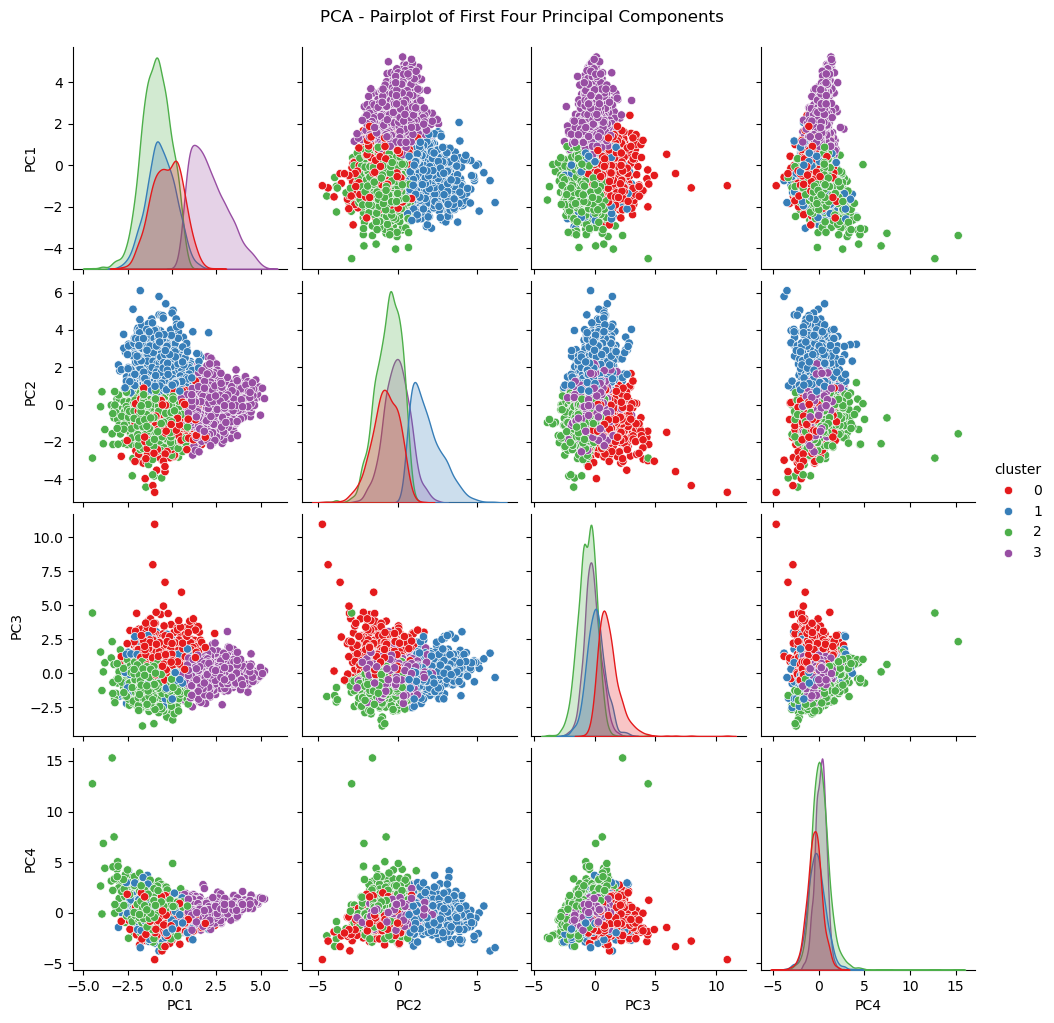

In [185]:
sns.pairplot(crime_pca_df, hue="cluster", vars=["PC1", "PC2", "PC3", "PC4"], palette="Set1")
plt.suptitle("PCA - Pairplot of First Four Principal Components", y=1.02)
plt.show()


In [182]:
# 计算每个聚类的犯罪均值
numeric_cols = london_crime24.select_dtypes(include=[np.number]).columns
cluster_summary = london_crime24.groupby("cluster_kmeans")[numeric_cols].mean()
print(cluster_summary)


                ARSON AND CRIMINAL DAMAGE  BURGLARY  DRUG OFFENCES  \
cluster_kmeans                                                       
0                                0.074594  0.069753       0.087202   
1                                0.078199  0.125087       0.032334   
2                                0.097526  0.063593       0.040118   
3                                0.051951  0.062534       0.034418   

                MISCELLANEOUS CRIMES AGAINST SOCIETY  POSSESSION OF WEAPONS  \
cluster_kmeans                                                                
0                                           0.012521               0.012949   
1                                           0.011928               0.002577   
2                                           0.017807               0.004012   
3                                           0.007299               0.003781   

                PUBLIC ORDER OFFENCES   ROBBERY     THEFT  VEHICLE OFFENCES  \
cluster_kmeans           

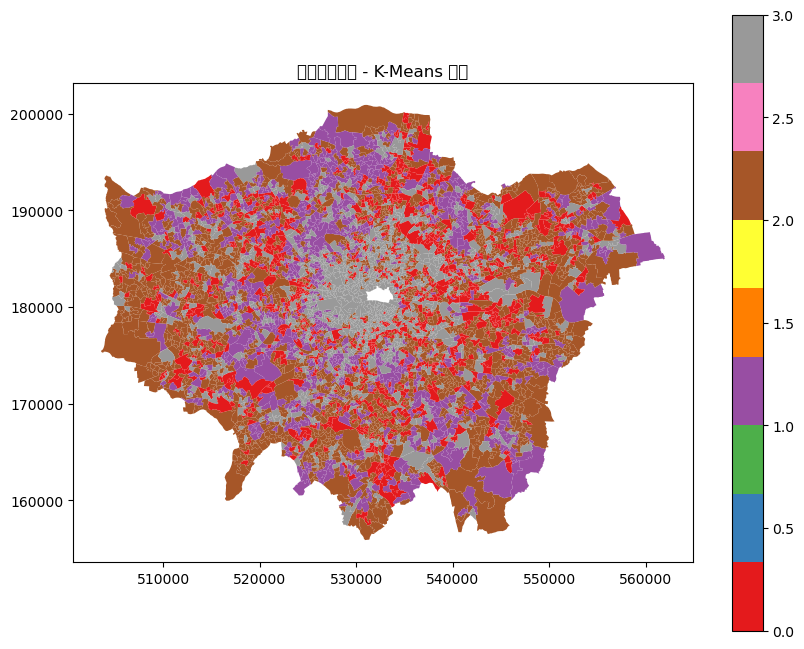

In [183]:
# 画地图
fig, ax = plt.subplots(figsize=(10, 8))
london_crime24.plot(column="cluster_kmeans", cmap="Set1", edgecolor="black", linewidth=0, legend=True, ax=ax)
plt.title("伦敦犯罪模式 - K-Means 聚类")
plt.show()


### split

In [5]:
crime10_23 = pd.read_csv('./data/MPS LSOA Level Crime (Historical).csv')
crime10_23.head()

LSOA Code                  LSOA Name    Borough             Major Category  \
0  E01000006  Barking and Dagenham 016A  E09000002  ARSON AND CRIMINAL DAMAGE   
1  E01000006  Barking and Dagenham 016A  E09000002  ARSON AND CRIMINAL DAMAGE   
2  E01000006  Barking and Dagenham 016A  E09000002                   BURGLARY   
3  E01000006  Barking and Dagenham 016A  E09000002                   BURGLARY   
4  E01000006  Barking and Dagenham 016A  E09000002              DRUG OFFENCES   

                    Minor Category  201903  201904  201905  201906  201907  \
0                            ARSON       1       0       0       0       0   
1                  CRIMINAL DAMAGE       1       2       0       1       0   
2  BURGLARY BUSINESS AND COMMUNITY       0       0       0       0       0   
3           BURGLARY IN A DWELLING       1       0       3       1       0   
4              POSSESSION OF DRUGS       2       2       0       0       0   

   ...  202204  202205  202206  202207  202208  202209  202210  202211  \
0  ...       0       0       0       0       0       0       0       0   
1  ...       0       0       0       2       1       0       0       0   
2  ...       0       0       0       0       0       0       0       0   
3  ...       0       0       0       0       0       0       0       2   
4  ...       1       2       0       0       1       0       4       1   

   202212  202301  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 159 columns]

In [6]:
major_cats = crime10_23['Major Category'].unique()
minor_cats = crime10_23['Minor Category'].unique()
print(major_cats)
print(minor_cats)

['ARSON AND CRIMINAL DAMAGE' 'BURGLARY' 'DRUG OFFENCES'
 'MISCELLANEOUS CRIMES AGAINST SOCIETY' 'POSSESSION OF WEAPONS'
 'PUBLIC ORDER OFFENCES' 'ROBBERY' 'THEFT' 'VEHICLE OFFENCES'
 'VIOLENCE AGAINST THE PERSON']
['ARSON' 'CRIMINAL DAMAGE' 'BURGLARY BUSINESS AND COMMUNITY'
 'BURGLARY IN A DWELLING' 'POSSESSION OF DRUGS' 'TRAFFICKING OF DRUGS'
 'MISC CRIMES AGAINST SOCIETY' 'POSSESSION OF WEAPONS'
 'OTHER OFFENCES PUBLIC ORDER' 'PUBLIC FEAR ALARM OR DISTRESS'
 'RACE OR RELIGIOUS AGG PUBLIC FEAR' 'ROBBERY OF PERSONAL PROPERTY'
 'BICYCLE THEFT' 'OTHER THEFT' 'THEFT FROM THE PERSON'
 'INTERFERING WITH A MOTOR VEHICLE' 'THEFT FROM A VEHICLE'
 'THEFT OR UNAUTH TAKING OF A MOTOR VEH' 'VIOLENCE WITH INJURY'
 'VIOLENCE WITHOUT INJURY' 'VIOLENT DISORDER'
 'ROBBERY OF BUSINESS PROPERTY' 'SHOPLIFTING' 'AGGRAVATED VEHICLE TAKING'
 'HOMICIDE']
